In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 5.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pylab
from matplotlib import pyplot
%matplotlib inline

In [ ]:
data = yf.download('AMZN',
                   start='2020-06-01',
                   interval='1h',
                   end='2021-06-01',
                   progress=False)[['Close']]
data

,Close
2020-06-01 09:30:00-04:00,2472.007568
2020-06-01 10:30:00-04:00,2461.639893
2020-06-01 11:30:00-04:00,2468.232910
2020-06-01 12:30:00-04:00,2470.982422
2020-06-01 13:30:00-04:00,2467.334961
...,...
2021-05-28 11:30:00-04:00,3244.459961
2021-05-28 12:30:00-04:00,3231.000000
2021-05-28 13:30:00-04:00,3230.409912
2021-05-28 14:30:00-04:00,3232.741211


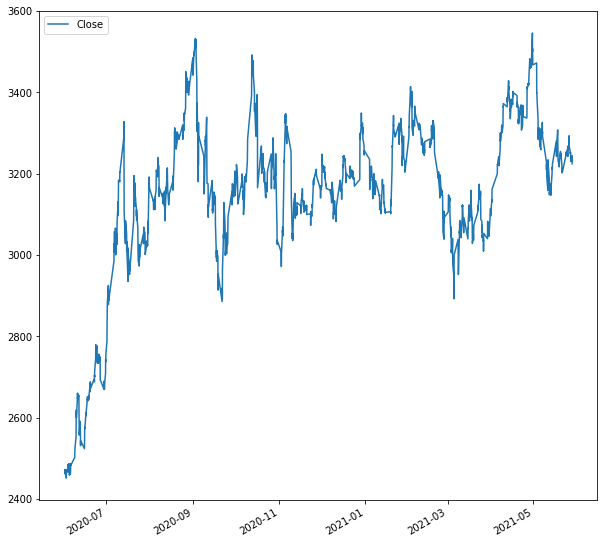

In [ ]:
data.plot(figsize=(10,10))

In [ ]:
def process_data(data, lb):
    X,Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i:(i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)

In [ ]:
cl_df = data.Close.astype('float32')

train_scl = cl_df[0:int(len(cl_df)*0.80)]
scl = MinMaxScaler()

#Scale the data
scl.fit(train_scl.values.reshape(-1,1))
cl_df = scl.transform(cl_df.values.reshape(-1,1))
 
step = 10
X, y = process_data(cl_df, step)
X_train, X_validation, X_test = X[:int(X.shape[0] * 0.80)], X[int(X.shape[0] * 0.80):int(X.shape[0] * 0.90)], X[int(X.shape[0] * 0.90):]
y_train, y_validation, y_test = y[:int(y.shape[0] * 0.80)], y[int(y.shape[0] * 0.80):int(y.shape[0] * 0.90)], y[int(y.shape[0] * 0.90):]

# print(X_train)
print(y_train)

[0.01250958 0.01521754 0.01252556 ... 0.5814402  0.56127286 0.5482702 ]


In [ ]:
#Reshape data for (Sample, Timestep, Features) 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_validation = X_validation.reshape((X_validation.shape[0], X_validation.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# print(X_test)

In [ ]:
model_1 = Sequential()

model_1.add(Dense(units=32, input_dim=10, activation='relu'))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1))

model_1.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse', 'mae'])

In [ ]:
model_2 = Sequential()

model_2.add(Dense(units=32, input_dim=10, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(1))

model_2.layers[0].set_weights([model_1.layers[0].get_weights()[0], model_1.layers[0].get_weights()[1]])
model_2.layers[1].set_weights([model_1.layers[1].get_weights()[0], model_1.layers[1].get_weights()[1]])
model_2.layers[2].set_weights([model_1.layers[2].get_weights()[0], model_1.layers[2].get_weights()[1]])

model_2.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse', 'mae'])

In [ ]:
random_weights = [np.random.rand(*w.shape) for w in model_1.get_weights()]

# update
model_1.set_weights(random_weights)
model_2.set_weights(random_weights)

In [ ]:
np.save('/content/gdrive/MyDrive/yield-paper/save_model/random_weights.npy', random_weights)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
weights_1 = []
initial_biases_1 = []

for i in range(len(model_1.layers)):
    weights_1.append(model_1.layers[i].get_weights()[0])
    initial_biases_1.append(model_1.layers[i].get_weights()[1])

# print(weights1)
print(initial_biases_1)

[array([0.15940025, 0.71350724, 0.5896902 , 0.6611655 , 0.19235447,
       0.14555109, 0.5802451 , 0.03904494, 0.18861467, 0.7328079 ,
       0.08613548, 0.47286564, 0.835954  , 0.690621  , 0.24087493,
       0.16522425, 0.36184782, 0.36009878, 0.8939895 , 0.00971647,
       0.14861041, 0.72599244, 0.98891383, 0.5936873 , 0.6236701 ,
       0.88022244, 0.45561084, 0.75259835, 0.11090061, 0.10709599,
       0.7597423 , 0.14739928], dtype=float32), array([0.94648314, 0.01053273, 0.7723272 , 0.812626  , 0.8257013 ,
       0.42518672, 0.70408535, 0.33508557], dtype=float32), array([0.5034336], dtype=float32)]


In [ ]:
weights_2 = []
initial_biases_2 = []

for i in range(len(model_2.layers)):
    weights_2.append(model_2.layers[i].get_weights()[0])
    initial_biases_2.append(model_2.layers[i].get_weights()[1])

# print(weights2)
print(initial_biases_2)

[array([0.15940025, 0.71350724, 0.5896902 , 0.6611655 , 0.19235447,
       0.14555109, 0.5802451 , 0.03904494, 0.18861467, 0.7328079 ,
       0.08613548, 0.47286564, 0.835954  , 0.690621  , 0.24087493,
       0.16522425, 0.36184782, 0.36009878, 0.8939895 , 0.00971647,
       0.14861041, 0.72599244, 0.98891383, 0.5936873 , 0.6236701 ,
       0.88022244, 0.45561084, 0.75259835, 0.11090061, 0.10709599,
       0.7597423 , 0.14739928], dtype=float32), array([0.94648314, 0.01053273, 0.7723272 , 0.812626  , 0.8257013 ,
       0.42518672, 0.70408535, 0.33508557], dtype=float32), array([0.5034336], dtype=float32)]


In [ ]:
import tensorflow as tf
from tensorflow import keras


early_stop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    restore_best_weights=True)

In [ ]:
model_1.fit(X_train,
           y_train,
           epochs=500,
           validation_data=(X_validation, y_validation),
           callbacks=[early_stop_callback],
           shuffle=False)

Epoch 1/500
44/44 [==============================] - 1s 7ms/step - loss: 68820.7656 - mse: 68820.7656 - mae: 253.9157 - val_loss: 66611.8203 - val_mse: 66611.8203 - val_mae: 255.3170
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 43391.3828 - mse: 43391.3828 - mae: 201.5821 - val_loss: 43470.7422 - val_mse: 43470.7422 - val_mae: 206.2531
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 29038.6523 - mse: 29038.6523 - mae: 164.8938 - val_loss: 29784.0371 - val_mse: 29784.0371 - val_mae: 170.7228
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 20251.2285 - mse: 20251.2285 - mae: 137.6932 - val_loss: 21128.2227 - val_mse: 21128.2227 - val_mae: 143.7900
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 14556.3955 - mse: 14556.3955 - mae: 116.7316 - val_loss: 15384.4541 - val_mse: 15384.4541 - val_mae: 122.6975
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10707.2168 -

In [ ]:
y_pred_val_mod_1 = model_1.predict(X_validation)
print(mean_squared_error(y_validation, y_pred_val_mod_1))

0.0043867948


In [ ]:
y_pred_test_mod_1 = model_1.predict(X_test)
print(mean_squared_error(y_test, y_pred_test_mod_1))

0.0063303695


In [ ]:
y_train_disturbed = y_train + 0.01
y_validation_disturbed = y_validation + 0.01

print(y_train)
print(y_validation_disturbed)

[0.01250958 0.01521754 0.01252556 ... 0.5814402  0.56127286 0.5482702 ]
[0.5436492  0.5637286  0.55096817 0.5590892  0.5684421  0.5683589
 0.5737059  0.58500147 0.6140592  0.62386537 0.6255491  0.6194711
 0.6300359  0.62876844 0.6205075  0.65542555 0.67749405 0.6682706
 0.67520905 0.67830515 0.64858437 0.6446805  0.652678   0.6622946
 0.64540195 0.62631345 0.6264558  0.62216306 0.5981195  0.5942342
 0.5694504  0.58512187 0.57328963 0.5569172  0.56160545 0.5602734
 0.5590615  0.54882956 0.55236363 0.55019903 0.52585936 0.5436492
 0.566638   0.5544915  0.57489944 0.58502007 0.5938549  0.58284855
 0.59223604 0.5884893  0.55985713 0.56373334 0.56650853 0.56743383
 0.563869   0.57859063 0.5691452  0.60943365 0.6133468  0.61948967
 0.6229384  0.61194086 0.6095307  0.6059644  0.6368356  0.636914
 0.64330196 0.63774204 0.64616513 0.6601944  0.66692924 0.70218515
 0.714628   0.7231777  0.72215843 0.7242212  0.72510004 0.725868
 0.7412343  0.7362571  0.73000264 0.72067356 0.73673797 0.737344
 0.

In [ ]:
model_2.fit(X_train,
           y_train_disturbed,
           epochs=500,
           validation_data=(X_validation, y_validation_disturbed),
           callbacks=[early_stop_callback],
           shuffle=False)

Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 68815.7578 - mse: 68815.7578 - mae: 253.9058 - val_loss: 66606.8125 - val_mse: 66606.8125 - val_mae: 255.3072
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 43387.4844 - mse: 43387.4844 - mae: 201.5724 - val_loss: 43466.8125 - val_mse: 43466.8125 - val_mae: 206.2436
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 29035.5508 - mse: 29035.5508 - mae: 164.8844 - val_loss: 29780.9082 - val_mse: 29780.9082 - val_mae: 170.7136
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 20248.7324 - mse: 20248.7324 - mae: 137.6841 - val_loss: 21125.6934 - val_mse: 21125.6934 - val_mae: 143.7812
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 14554.3643 - mse: 14554.3643 - mae: 116.7228 - val_loss: 15382.3916 - val_mse: 15382.3916 - val_mae: 122.6890
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10705.5391 -

In [ ]:
def get_delta(model_1, model_2):
  delta_matrix = []

  for i in range(len(model_1.layers)):
    normal_weights = model_1.layers[i].get_weights()[0]
    # print("IN DELTA: NORMAL WEIGHTS")
    # print(normal_weights)

    disturbed_weights = model_2.layers[i].get_weights()[0]
    # print("IN DELTA: DISTURBED WEIGHTS")
    # print(disturbed_weights)
    # print(np.abs(np.divide(np.subtract(disturbed_weights, normal_weights), disturbed_weights)))

    delta_matrix.append(np.abs(np.divide(np.subtract(disturbed_weights, normal_weights), disturbed_weights)))
  return delta_matrix

In [ ]:
class FreezeWeights(keras.callbacks.Callback):
  def __init__(self, mask):
        super(FreezeWeights, self).__init__()
        self.mask = mask

  def on_epoch_end(self, epoch, logs=None):
    for i in range(len(self.model.layers)):
      self.model.layers[i].set_weights([np.multiply(self.model.layers[i].get_weights()[0], self.mask[i]), self.model.layers[i].get_weights()[1]])

In [ ]:
def plot_graph(values, y_label, x_label, color):
  len_prediction=[x for x in range(len(values))]
  plt.figure(figsize=(8,4))
  plt.plot(len_prediction, values, color, linestyle='--')
  plt.ylabel(y_label, size=15)
  plt.xlabel(x_label, size=15)
  plt.show();

In [ ]:
def plot_log_graph(values, y_label, x_label, color):
  len_prediction=[x for x in range(len(values))]
  pyplot.plot(len_prediction, values, color, linestyle='--')
  pyplot.yscale('log')
  plt.ylabel(y_label, size=15)
  plt.xlabel(x_label, size=15)
  pyplot.show()

In [ ]:
def get_model():
  model = Sequential()

  model.add(Dense(units=32, input_dim=10, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse', 'mae'])
  
  return model

In [ ]:
early_stop_callback_reduct = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    restore_best_weights=False)

In [ ]:
def reduct(model_1, model_2, weights, initial_biases_1, initial_biases_2):
  mask_matrix = []
  validation_MSE = []
  test_MSE = []
  deviation = []
  best_model_weights = []
  k = 0

  while(k != 100):
    delta_matrix = get_delta(model_1, model_2)

    converted_delta_matrix = []
    for i in range(len(delta_matrix)):
      delta_matrix[i] = np.nan_to_num(delta_matrix[i])
      converted_delta_matrix.append(np.where(delta_matrix[i] == 0, 1, delta_matrix[i]))
    
    max_elements = []
    min_elements = []

    if k == 0:
      for i in range(len(delta_matrix)):
        mask_matrix.append(np.ones_like(delta_matrix[i]))
    
    for i in range(len(model_1.layers)):
      max_elements.append(np.max(np.asarray(delta_matrix[i])))
      min_elements.append(np.min(np.asarray(converted_delta_matrix[i])))
    
    max_element = np.max(np.asarray(max_elements))
    min_element = np.min(np.asarray(min_elements))
    deviation.append(max_element - min_element)

    max_element_layer_index =  np.unravel_index(np.argmax(np.asarray(max_elements), axis=None),np.asarray(max_elements).shape)[0]
    max_element_indexes= np.unravel_index(np.argmax(delta_matrix[max_element_layer_index], axis=None), delta_matrix[max_element_layer_index].shape)
    mask_matrix[max_element_layer_index][max_element_indexes] = 0
    k += 1

    model_1 = get_model()
    model_2 = get_model()

    for i in range(len(model_1.layers)):
      model_1.layers[i].set_weights([np.multiply(weights[i], mask_matrix[i]), initial_biases_1[i]])
      model_2.layers[i].set_weights([np.multiply(weights[i], mask_matrix[i]), initial_biases_2[i]])
    
    model_1.fit(X_train,
                y_train,
                epochs=500,
                validation_data=(X_validation, y_validation),
                shuffle=False,
                callbacks=[FreezeWeights(mask_matrix), early_stop_callback])
    
    model_2.fit(X_train,
                y_train_disturbed,
                epochs=500,
                validation_data=(X_validation, y_validation_disturbed),
                shuffle=False,
                callbacks=[FreezeWeights(mask_matrix), early_stop_callback])
    
    y_pred_validation = model_1.predict(X_validation)
    validation_MSE.append(mean_squared_error(y_validation, y_pred_validation))

    if validation_MSE[-1] == np.min(validation_MSE):
      best_model_weights = []
      for i in range(len(model_1.layers)):
          best_model_weights.append([model_1.layers[i].get_weights()[0], model_1.layers[i].get_weights()[1]])
    
    y_pred_test = model_1.predict(X_test)
    test_MSE.append(mean_squared_error(y_test, y_pred_test))
  
  return validation_MSE, test_MSE, deviation, best_model_weights


validation_MSE, test_MSE, deviation, best_model_weights = reduct(model_1, model_2, weights_1, initial_biases_1, initial_biases_2)

Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 68558.8125 - mse: 68558.8125 - mae: 253.4374 - val_loss: 66341.8438 - val_mse: 66341.8438 - val_mae: 254.8007
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 43235.4336 - mse: 43235.4336 - mae: 201.2236 - val_loss: 43304.1523 - val_mse: 43304.1523 - val_mae: 205.8587
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 28938.4238 - mse: 28938.4238 - mae: 164.6122 - val_loss: 29674.4824 - val_mse: 29674.4824 - val_mae: 170.4094
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 20183.4844 - mse: 20183.4844 - mae: 137.4653 - val_loss: 21052.9785 - val_mse: 21052.9785 - val_mae: 143.5344
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 14508.8682 - mse: 14508.8682 - mae: 116.5428 - val_loss: 15331.0312 - val_mse: 15331.0312 - val_mae: 122.4848
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10672.8770 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 67901.2109 - mse: 67901.2109 - mae: 252.2142 - val_loss: 65666.8047 - val_mse: 65666.8047 - val_mae: 253.4996
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 42830.5352 - mse: 42830.5352 - mae: 200.2753 - val_loss: 42875.3711 - val_mse: 42875.3711 - val_mae: 204.8358
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 28671.7480 - mse: 28671.7480 - mae: 163.8488 - val_loss: 29386.1777 - val_mse: 29386.1777 - val_mae: 169.5785
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 19999.9590 - mse: 19999.9590 - mae: 136.8363 - val_loss: 20851.5273 - val_mse: 20851.5273 - val_mae: 142.8452
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 14378.4023 - mse: 14378.4023 - mae: 116.0155 - val_loss: 15186.1475 - val_mse: 15186.1475 - val_mae: 121.9039
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10577.8027 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 67615.9141 - mse: 67615.9141 - mae: 251.6896 - val_loss: 65373.0898 - val_mse: 65373.0898 - val_mae: 252.9337
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 42660.8008 - mse: 42660.8008 - mae: 199.8825 - val_loss: 42694.3359 - val_mse: 42694.3359 - val_mae: 204.4041
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 28562.8848 - mse: 28562.8848 - mae: 163.5409 - val_loss: 29267.3516 - val_mse: 29267.3516 - val_mae: 169.2363
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 19926.5605 - mse: 19926.5605 - mae: 136.5878 - val_loss: 20770.0723 - val_mse: 20770.0723 - val_mae: 142.5667
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 14327.0205 - mse: 14327.0205 - mae: 115.8103 - val_loss: 15128.3955 - val_mse: 15128.3955 - val_mae: 121.6725
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10540.7236 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 8ms/step - loss: 66997.9297 - mse: 66997.9297 - mae: 250.5336 - val_loss: 64740.4688 - val_mse: 64740.4688 - val_mae: 251.7059
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 42281.1133 - mse: 42281.1133 - mae: 198.9885 - val_loss: 42293.1797 - val_mse: 42293.1797 - val_mae: 203.4408
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 28313.0059 - mse: 28313.0059 - mae: 162.8220 - val_loss: 28997.7695 - val_mse: 28997.7695 - val_mae: 168.4544
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 19754.4922 - mse: 19754.4922 - mae: 135.9951 - val_loss: 20581.5762 - val_mse: 20581.5762 - val_mae: 141.9177
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 14204.4561 - mse: 14204.4561 - mae: 115.3125 - val_loss: 14992.5576 - val_mse: 14992.5576 - val_mae: 121.1245
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10451.1113 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 66636.4375 - mse: 66636.4375 - mae: 249.8638 - val_loss: 64371.0000 - val_mse: 64371.0000 - val_mae: 250.9890
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 42069.2109 - mse: 42069.2109 - mae: 198.4951 - val_loss: 42068.0195 - val_mse: 42068.0195 - val_mae: 202.9004
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 28178.2012 - mse: 28178.2012 - mae: 162.4389 - val_loss: 28850.7695 - val_mse: 28850.7695 - val_mae: 168.0285
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 19663.7754 - mse: 19663.7754 - mae: 135.6867 - val_loss: 20480.7852 - val_mse: 20480.7852 - val_mae: 141.5711
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 14140.7598 - mse: 14140.7598 - mae: 115.0572 - val_loss: 14920.8086 - val_mse: 14920.8086 - val_mae: 120.8355
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10404.8965 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 66254.2031 - mse: 66254.2031 - mae: 249.1510 - val_loss: 63980.0352 - val_mse: 63980.0352 - val_mae: 250.2272
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 41843.6562 - mse: 41843.6562 - mae: 197.9663 - val_loss: 41828.4180 - val_mse: 41828.4180 - val_mae: 202.3231
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 28034.0020 - mse: 28034.0020 - mae: 162.0261 - val_loss: 28693.6855 - val_mse: 28693.6855 - val_mae: 167.5715
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 19566.3848 - mse: 19566.3848 - mae: 135.3532 - val_loss: 20372.7773 - val_mse: 20372.7773 - val_mae: 141.1983
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 14072.1963 - mse: 14072.1963 - mae: 114.7805 - val_loss: 14843.7744 - val_mse: 14843.7744 - val_mae: 120.5240
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10355.0537 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 65868.6562 - mse: 65868.6562 - mae: 248.4304 - val_loss: 63583.8359 - val_mse: 63583.8359 - val_mae: 249.4530
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 41615.4219 - mse: 41615.4219 - mae: 197.4301 - val_loss: 41584.9688 - val_mse: 41584.9688 - val_mae: 201.7349
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 27887.8828 - mse: 27887.8828 - mae: 161.6071 - val_loss: 28533.9180 - val_mse: 28533.9180 - val_mae: 167.1055
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 19467.7734 - mse: 19467.7734 - mae: 135.0148 - val_loss: 20263.0176 - val_mse: 20263.0176 - val_mae: 140.8184
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 14002.9688 - mse: 14002.9688 - mae: 114.5005 - val_loss: 14765.7031 - val_mse: 14765.7031 - val_mae: 120.2074
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10304.9453 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 65590.2031 - mse: 65590.2031 - mae: 247.9033 - val_loss: 63305.3438 - val_mse: 63305.3438 - val_mae: 248.9057
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 41453.0820 - mse: 41453.0820 - mae: 197.0435 - val_loss: 41415.9414 - val_mse: 41415.9414 - val_mae: 201.3241
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 27784.6270 - mse: 27784.6270 - mae: 161.3067 - val_loss: 28423.5117 - val_mse: 28423.5117 - val_mae: 166.7816
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 19398.0957 - mse: 19398.0957 - mae: 134.7722 - val_loss: 20187.1035 - val_mse: 20187.1035 - val_mae: 140.5541
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 13953.8457 - mse: 13953.8457 - mae: 114.2989 - val_loss: 14711.4453 - val_mse: 14711.4453 - val_mae: 119.9862
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10269.1357 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 65354.8555 - mse: 65354.8555 - mae: 247.4632 - val_loss: 63063.7812 - val_mse: 63063.7812 - val_mae: 248.4319
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 41316.1562 - mse: 41316.1562 - mae: 196.7215 - val_loss: 41269.9102 - val_mse: 41269.9102 - val_mae: 200.9700
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 27698.2891 - mse: 27698.2891 - mae: 161.0586 - val_loss: 28329.1113 - val_mse: 28329.1113 - val_mae: 166.5053
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 19340.6094 - mse: 19340.6094 - mae: 134.5746 - val_loss: 20123.1211 - val_mse: 20123.1211 - val_mae: 140.3318
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13913.9258 - mse: 13913.9258 - mae: 114.1370 - val_loss: 14666.4111 - val_mse: 14666.4111 - val_mae: 119.8029
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10240.4326 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 65187.9609 - mse: 65187.9609 - mae: 247.1497 - val_loss: 62892.8359 - val_mse: 62892.8359 - val_mae: 248.0957
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 41222.2305 - mse: 41222.2305 - mae: 196.4996 - val_loss: 41169.4766 - val_mse: 41169.4766 - val_mae: 200.7259
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 27640.3555 - mse: 27640.3555 - mae: 160.8915 - val_loss: 28265.4277 - val_mse: 28265.4277 - val_mae: 166.3185
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 19302.5020 - mse: 19302.5020 - mae: 134.4429 - val_loss: 20080.4336 - val_mse: 20080.4336 - val_mae: 140.1832
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13887.5459 - mse: 13887.5459 - mae: 114.0294 - val_loss: 14636.4727 - val_mse: 14636.4727 - val_mae: 119.6807
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10221.3770 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 65000.5117 - mse: 65000.5117 - mae: 246.7978 - val_loss: 62700.6289 - val_mse: 62700.6289 - val_mae: 247.7175
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 41114.4453 - mse: 41114.4453 - mae: 196.2452 - val_loss: 41054.3789 - val_mse: 41054.3789 - val_mae: 200.4459
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 27572.8535 - mse: 27572.8535 - mae: 160.6969 - val_loss: 28191.4199 - val_mse: 28191.4199 - val_mae: 166.1012
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 19257.6855 - mse: 19257.6855 - mae: 134.2883 - val_loss: 20030.3984 - val_mse: 20030.3984 - val_mae: 140.0089
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 13856.4268 - mse: 13856.4268 - mae: 113.9028 - val_loss: 14601.2773 - val_mse: 14601.2773 - val_mae: 119.5371
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10198.9609 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 64955.6719 - mse: 64955.6719 - mae: 246.7137 - val_loss: 62656.5469 - val_mse: 62656.5469 - val_mae: 247.6307
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 41096.3594 - mse: 41096.3594 - mae: 196.2025 - val_loss: 41034.6172 - val_mse: 41034.6172 - val_mae: 200.3978
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 27564.2930 - mse: 27564.2930 - mae: 160.6722 - val_loss: 28181.0391 - val_mse: 28181.0391 - val_mae: 166.0707
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 19252.6348 - mse: 19252.6348 - mae: 134.2708 - val_loss: 20023.7480 - val_mse: 20023.7480 - val_mae: 139.9857
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13852.5850 - mse: 13852.5850 - mae: 113.8870 - val_loss: 14596.0459 - val_mse: 14596.0459 - val_mae: 119.5157
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10195.4443 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 64433.8125 - mse: 64433.8125 - mae: 245.7291 - val_loss: 62117.9648 - val_mse: 62117.9648 - val_mae: 246.5669
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 40771.6523 - mse: 40771.6523 - mae: 195.4331 - val_loss: 40688.3867 - val_mse: 40688.3867 - val_mae: 199.5530
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 27348.2695 - mse: 27348.2695 - mae: 160.0477 - val_loss: 27945.4980 - val_mse: 27945.4980 - val_mae: 165.3772
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 19102.2480 - mse: 19102.2480 - mae: 133.7509 - val_loss: 19856.9531 - val_mse: 19856.9531 - val_mae: 139.4032
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13744.2109 - mse: 13744.2109 - mae: 113.4456 - val_loss: 14474.1973 - val_mse: 14474.1973 - val_mae: 119.0174
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10115.1543 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 64078.5781 - mse: 64078.5781 - mae: 245.0571 - val_loss: 61747.0117 - val_mse: 61747.0117 - val_mae: 245.8315
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 40553.6914 - mse: 40553.6914 - mae: 194.9149 - val_loss: 40453.3789 - val_mse: 40453.3789 - val_mae: 198.9774
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 27205.1055 - mse: 27205.1055 - mae: 159.6322 - val_loss: 27787.8965 - val_mse: 27787.9004 - val_mae: 164.9115
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 19003.8984 - mse: 19003.8984 - mae: 133.4093 - val_loss: 19747.0801 - val_mse: 19747.0801 - val_mae: 139.0180
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13674.3340 - mse: 13674.3340 - mae: 113.1594 - val_loss: 14395.2686 - val_mse: 14395.2686 - val_mae: 118.6932
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10064.1758 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 63847.7383 - mse: 63847.7383 - mae: 244.6201 - val_loss: 61509.8281 - val_mse: 61509.8281 - val_mae: 245.3604
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 40419.5312 - mse: 40419.5312 - mae: 194.5957 - val_loss: 40310.1133 - val_mse: 40310.1133 - val_mae: 198.6258
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 27120.6055 - mse: 27120.6055 - mae: 159.3867 - val_loss: 27695.3711 - val_mse: 27695.3711 - val_mae: 164.6375
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18947.6777 - mse: 18947.6777 - mae: 133.2139 - val_loss: 19684.4199 - val_mse: 19684.4199 - val_mae: 138.7979
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13635.3193 - mse: 13635.3193 - mae: 112.9995 - val_loss: 14351.2012 - val_mse: 14351.2012 - val_mae: 118.5119
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 10036.1240 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 63429.7188 - mse: 63429.7188 - mae: 243.8159 - val_loss: 61084.6055 - val_mse: 61084.6055 - val_mae: 244.5102
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 40171.8125 - mse: 40171.8125 - mae: 193.9969 - val_loss: 40048.7812 - val_mse: 40048.7812 - val_mae: 197.9805
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 26962.1797 - mse: 26962.1797 - mae: 158.9193 - val_loss: 27524.1523 - val_mse: 27524.1523 - val_mae: 164.1274
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18841.1152 - mse: 18841.1152 - mae: 132.8378 - val_loss: 19567.2148 - val_mse: 19567.2148 - val_mae: 138.3837
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 13560.8857 - mse: 13560.8857 - mae: 112.6898 - val_loss: 14268.2568 - val_mse: 14268.2568 - val_mae: 118.1686
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9982.6084 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 63013.2734 - mse: 63013.2734 - mae: 243.0107 - val_loss: 60664.8555 - val_mse: 60664.8555 - val_mae: 243.6676
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 39921.1992 - mse: 39921.1992 - mae: 193.3881 - val_loss: 39787.1758 - val_mse: 39787.1758 - val_mae: 197.3319
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 26799.4473 - mse: 26799.4473 - mae: 158.4368 - val_loss: 27350.3086 - val_mse: 27350.3086 - val_mae: 163.6075
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18729.8945 - mse: 18729.8945 - mae: 132.4433 - val_loss: 19446.4121 - val_mse: 19446.4121 - val_mae: 137.9552
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 13481.8750 - mse: 13481.8750 - mae: 112.3595 - val_loss: 14181.3818 - val_mse: 14181.3818 - val_mae: 117.8078
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9924.7803 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 62673.4766 - mse: 62673.4766 - mae: 242.3510 - val_loss: 60322.2500 - val_mse: 60322.2500 - val_mae: 242.9775
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 39723.7734 - mse: 39723.7734 - mae: 192.9064 - val_loss: 39580.1641 - val_mse: 39580.1641 - val_mae: 196.8169
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 26674.9336 - mse: 26674.9336 - mae: 158.0660 - val_loss: 27216.2793 - val_mse: 27216.2793 - val_mae: 163.2054
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18646.8926 - mse: 18646.8926 - mae: 132.1477 - val_loss: 19355.3691 - val_mse: 19355.3691 - val_mae: 137.6313
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13424.1963 - mse: 13424.1963 - mae: 112.1175 - val_loss: 14117.2344 - val_mse: 14117.2344 - val_mae: 117.5406
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9883.3955 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 62606.4531 - mse: 62606.4531 - mae: 242.2229 - val_loss: 60256.4727 - val_mse: 60256.4727 - val_mae: 242.8454
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 39690.7656 - mse: 39690.7656 - mae: 192.8272 - val_loss: 39545.5391 - val_mse: 39545.5391 - val_mae: 196.7311
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 26656.2070 - mse: 26656.2070 - mae: 158.0110 - val_loss: 27195.6777 - val_mse: 27195.6777 - val_mae: 163.1438
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18634.8789 - mse: 18634.8789 - mae: 132.1055 - val_loss: 19341.7188 - val_mse: 19341.7188 - val_mae: 137.5829
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13415.6279 - mse: 13415.6279 - mae: 112.0819 - val_loss: 14107.2998 - val_mse: 14107.2998 - val_mae: 117.4992
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9876.7373 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 62366.6289 - mse: 62366.6289 - mae: 241.7620 - val_loss: 60013.2930 - val_mse: 60013.2930 - val_mae: 242.3560
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 39554.1602 - mse: 39554.1602 - mae: 192.4978 - val_loss: 39400.8164 - val_mse: 39400.8164 - val_mae: 196.3717
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 26570.9805 - mse: 26570.9805 - mae: 157.7604 - val_loss: 27102.7363 - val_mse: 27102.7363 - val_mae: 162.8655
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 18578.2344 - mse: 18578.2344 - mae: 131.9063 - val_loss: 19278.6836 - val_mse: 19278.6836 - val_mae: 137.3590
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 13376.1221 - mse: 13376.1221 - mae: 111.9182 - val_loss: 14062.7119 - val_mse: 14062.7119 - val_mae: 117.3138
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9848.1387 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 61997.6914 - mse: 61997.6914 - mae: 241.0520 - val_loss: 59637.4844 - val_mse: 59637.4844 - val_mae: 241.5979
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 39330.1758 - mse: 39330.1758 - mae: 191.9570 - val_loss: 39164.1016 - val_mse: 39164.1016 - val_mae: 195.7825
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 26424.0566 - mse: 26424.0566 - mae: 157.3279 - val_loss: 26943.3535 - val_mse: 26943.3535 - val_mae: 162.3872
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18476.3477 - mse: 18476.3477 - mae: 131.5478 - val_loss: 19165.8223 - val_mse: 19165.8223 - val_mae: 136.9576
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13302.1787 - mse: 13302.1787 - mae: 111.6116 - val_loss: 13979.2969 - val_mse: 13979.2969 - val_mae: 116.9664
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9792.2598 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 61774.1680 - mse: 61774.1680 - mae: 240.6216 - val_loss: 59408.4180 - val_mse: 59408.4180 - val_mae: 241.1349
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 39199.9883 - mse: 39199.9883 - mae: 191.6424 - val_loss: 39025.4570 - val_mse: 39025.4570 - val_mae: 195.4367
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 26341.8359 - mse: 26341.8359 - mae: 157.0855 - val_loss: 26853.5801 - val_mse: 26853.5801 - val_mae: 162.1172
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 18421.4551 - mse: 18421.4551 - mae: 131.3542 - val_loss: 19104.8223 - val_mse: 19104.8223 - val_mae: 136.7401
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13263.8965 - mse: 13263.8965 - mae: 111.4525 - val_loss: 13936.1885 - val_mse: 13936.1885 - val_mae: 116.7864
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9764.5703 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 61594.8984 - mse: 61594.8984 - mae: 240.2761 - val_loss: 59226.1602 - val_mse: 59226.1602 - val_mae: 240.7659
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 39095.6914 - mse: 39095.6914 - mae: 191.3900 - val_loss: 38915.0234 - val_mse: 38915.0234 - val_mae: 195.1608
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 26276.0371 - mse: 26276.0371 - mae: 156.8913 - val_loss: 26782.0293 - val_mse: 26782.0293 - val_mae: 161.9017
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18377.5547 - mse: 18377.5547 - mae: 131.1992 - val_loss: 19056.1445 - val_mse: 19056.1445 - val_mae: 136.5662
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13233.2578 - mse: 13233.2578 - mae: 111.3249 - val_loss: 13901.7129 - val_mse: 13901.7129 - val_mae: 116.6422
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9742.3457 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 7ms/step - loss: 61536.4141 - mse: 61536.4141 - mae: 240.1633 - val_loss: 59168.2930 - val_mse: 59168.2930 - val_mae: 240.6486
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 39069.9844 - mse: 39069.9844 - mae: 191.3278 - val_loss: 38887.3125 - val_mse: 38887.3125 - val_mae: 195.0915
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 26263.0352 - mse: 26263.0352 - mae: 156.8528 - val_loss: 26766.9062 - val_mse: 26766.9062 - val_mae: 161.8561
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18369.8164 - mse: 18369.8164 - mae: 131.1716 - val_loss: 19046.5723 - val_mse: 19046.5723 - val_mae: 136.5319
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13227.7021 - mse: 13227.7021 - mae: 111.3015 - val_loss: 13894.6084 - val_mse: 13894.6084 - val_mae: 116.6124
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9737.6631 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 7ms/step - loss: 61291.0312 - mse: 61291.0312 - mae: 239.6881 - val_loss: 58913.5938 - val_mse: 58913.5938 - val_mae: 240.1314
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 38926.2852 - mse: 38926.2852 - mae: 190.9787 - val_loss: 38732.4414 - val_mse: 38732.4414 - val_mae: 194.7036
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 26172.1914 - mse: 26172.1914 - mae: 156.5836 - val_loss: 26666.5625 - val_mse: 26666.5625 - val_mae: 161.5532
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18309.3730 - mse: 18309.3730 - mae: 130.9576 - val_loss: 18978.6289 - val_mse: 18978.6289 - val_mae: 136.2887
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 13185.8867 - mse: 13185.8867 - mae: 111.1269 - val_loss: 13846.9814 - val_mse: 13846.9814 - val_mae: 116.4128
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9707.7988 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 61056.9570 - mse: 61056.9570 - mae: 239.2333 - val_loss: 58677.8008 - val_mse: 58677.8008 - val_mae: 239.6514
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 38791.4297 - mse: 38791.4297 - mae: 190.6502 - val_loss: 38590.6016 - val_mse: 38590.6016 - val_mae: 194.3476
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 26087.0684 - mse: 26087.0684 - mae: 156.3310 - val_loss: 26574.4277 - val_mse: 26574.4277 - val_mae: 161.2745
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18252.0762 - mse: 18252.0762 - mae: 130.7544 - val_loss: 18915.3574 - val_mse: 18915.3574 - val_mae: 136.0619
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 13145.3799 - mse: 13145.3799 - mae: 110.9576 - val_loss: 13801.6104 - val_mse: 13801.6104 - val_mae: 116.2224
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9678.0488 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 60315.1016 - mse: 60315.1016 - mae: 237.7877 - val_loss: 57909.9648 - val_mse: 57909.9648 - val_mae: 238.0823
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 38317.0625 - mse: 38317.0625 - mae: 189.4917 - val_loss: 38083.3242 - val_mse: 38083.3242 - val_mae: 193.0695
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 25762.3730 - mse: 25762.3730 - mae: 155.3647 - val_loss: 26217.4492 - val_mse: 26217.4492 - val_mae: 160.1908
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 18016.8359 - mse: 18016.8359 - mae: 129.9178 - val_loss: 18649.4902 - val_mse: 18649.4902 - val_mae: 135.1052
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12965.1230 - mse: 12965.1230 - mae: 110.2023 - val_loss: 13592.0889 - val_mse: 13592.0889 - val_mae: 115.3394
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9531.8438 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 59936.1992 - mse: 59936.1992 - mae: 237.0377 - val_loss: 57525.7031 - val_mse: 57525.7031 - val_mae: 237.2906
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 38095.4414 - mse: 38095.4414 - mae: 188.9414 - val_loss: 37849.8047 - val_mse: 37849.8047 - val_mae: 192.4763
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 25622.2637 - mse: 25622.2637 - mae: 154.9405 - val_loss: 26065.9824 - val_mse: 26065.9824 - val_mae: 159.7270
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17923.5762 - mse: 17923.5762 - mae: 129.5802 - val_loss: 18546.7949 - val_mse: 18546.7949 - val_mae: 134.7324
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12900.6631 - mse: 12900.6631 - mae: 109.9273 - val_loss: 13520.1260 - val_mse: 13520.1260 - val_mae: 115.0334
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9486.0127 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 59679.4961 - mse: 59679.4961 - mae: 236.5284 - val_loss: 57267.7617 - val_mse: 57267.7617 - val_mae: 236.7576
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 37949.3125 - mse: 37949.3125 - mae: 188.5778 - val_loss: 37696.5039 - val_mse: 37696.5039 - val_mae: 192.0858
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 25531.3691 - mse: 25531.3691 - mae: 154.6648 - val_loss: 25967.7949 - val_mse: 25967.7949 - val_mae: 159.4257
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17863.4551 - mse: 17863.4551 - mae: 129.3623 - val_loss: 18480.4883 - val_mse: 18480.4883 - val_mae: 134.4911
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12858.9717 - mse: 12858.9717 - mae: 109.7492 - val_loss: 13473.4385 - val_mse: 13473.4404 - val_mae: 114.8345
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9456.0049 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 59402.8086 - mse: 59402.8086 - mae: 235.9840 - val_loss: 56986.3086 - val_mse: 56986.3086 - val_mae: 236.1767
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 37792.5273 - mse: 37792.5273 - mae: 188.1914 - val_loss: 37529.8750 - val_mse: 37529.8750 - val_mae: 191.6620
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 25434.3555 - mse: 25434.3555 - mae: 154.3736 - val_loss: 25861.6289 - val_mse: 25861.6289 - val_mae: 159.1004
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17799.6074 - mse: 17799.6074 - mae: 129.1333 - val_loss: 18409.1582 - val_mse: 18409.1582 - val_mae: 134.2321
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12814.9150 - mse: 12814.9150 - mae: 109.5630 - val_loss: 13423.5186 - val_mse: 13423.5186 - val_mae: 114.6222
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9424.4756 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 59210.1875 - mse: 59210.1875 - mae: 235.6049 - val_loss: 56788.1133 - val_mse: 56788.1133 - val_mae: 235.7668
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 37681.0000 - mse: 37681.0000 - mae: 187.9164 - val_loss: 37410.4414 - val_mse: 37410.4414 - val_mae: 191.3577
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 25364.3438 - mse: 25364.3438 - mae: 154.1631 - val_loss: 25784.6777 - val_mse: 25784.6777 - val_mae: 158.8642
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17753.1855 - mse: 17753.1855 - mae: 128.9664 - val_loss: 18357.1914 - val_mse: 18357.1914 - val_mae: 134.0430
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12782.8193 - mse: 12782.8193 - mae: 109.4270 - val_loss: 13387.1143 - val_mse: 13387.1143 - val_mae: 114.4671
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9401.5283 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 58861.7148 - mse: 58861.7148 - mae: 234.9088 - val_loss: 56435.2461 - val_mse: 56435.2461 - val_mae: 235.0326
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 37478.6289 - mse: 37478.6289 - mae: 187.4097 - val_loss: 37197.2695 - val_mse: 37197.2695 - val_mae: 190.8113
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 25237.1523 - mse: 25237.1523 - mae: 153.7750 - val_loss: 25647.1465 - val_mse: 25647.1465 - val_mae: 158.4396
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17668.9844 - mse: 17668.9844 - mae: 128.6593 - val_loss: 18264.4336 - val_mse: 18264.4336 - val_mae: 133.7036
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12724.9199 - mse: 12724.9199 - mae: 109.1783 - val_loss: 13322.4600 - val_mse: 13322.4600 - val_mae: 114.1901
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9360.5850 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 58625.4258 - mse: 58625.4258 - mae: 234.4421 - val_loss: 56192.7656 - val_mse: 56192.7656 - val_mae: 234.5287
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 37340.2617 - mse: 37340.2617 - mae: 187.0673 - val_loss: 37049.7734 - val_mse: 37049.7734 - val_mae: 190.4337
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 25149.7109 - mse: 25149.7109 - mae: 153.5115 - val_loss: 25551.5820 - val_mse: 25551.5820 - val_mae: 158.1450
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17610.8301 - mse: 17610.8301 - mae: 128.4499 - val_loss: 18199.7207 - val_mse: 18199.7207 - val_mae: 133.4673
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12684.6963 - mse: 12684.6963 - mae: 109.0075 - val_loss: 13277.0811 - val_mse: 13277.0811 - val_mae: 113.9960
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9331.8516 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 58389.7656 - mse: 58389.7656 - mae: 233.9755 - val_loss: 55950.3477 - val_mse: 55950.3477 - val_mae: 234.0239
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 37197.3555 - mse: 37197.3555 - mae: 186.7128 - val_loss: 36897.4766 - val_mse: 36897.4766 - val_mae: 190.0432
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 25056.6855 - mse: 25056.6855 - mae: 153.2303 - val_loss: 25450.1426 - val_mse: 25450.1426 - val_mae: 157.8317
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17547.3340 - mse: 17547.3340 - mae: 128.2205 - val_loss: 18129.3516 - val_mse: 18129.3516 - val_mae: 133.2097
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12639.7666 - mse: 12639.7666 - mae: 108.8162 - val_loss: 13226.6885 - val_mse: 13226.6885 - val_mae: 113.7800
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9299.1230 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 58110.3711 - mse: 58110.3711 - mae: 233.4137 - val_loss: 55668.8008 - val_mse: 55668.8008 - val_mae: 233.4339
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 37037.8008 - mse: 37037.8008 - mae: 186.3108 - val_loss: 36729.7617 - val_mse: 36729.7617 - val_mae: 189.6104
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 24957.5762 - mse: 24957.5762 - mae: 152.9261 - val_loss: 25343.0391 - val_mse: 25343.0391 - val_mae: 157.4990
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17482.1895 - mse: 17482.1895 - mae: 127.9816 - val_loss: 18057.5898 - val_mse: 18057.5898 - val_mae: 132.9456
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12595.1113 - mse: 12595.1113 - mae: 108.6233 - val_loss: 13176.8496 - val_mse: 13176.8496 - val_mae: 113.5653
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9267.5498 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 58069.1797 - mse: 58069.1797 - mae: 233.3319 - val_loss: 55631.9961 - val_mse: 55631.9961 - val_mae: 233.3570
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 37014.5234 - mse: 37014.5234 - mae: 186.2530 - val_loss: 36707.3438 - val_mse: 36707.3438 - val_mae: 189.5527
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 24943.1973 - mse: 24943.1973 - mae: 152.8826 - val_loss: 25328.4121 - val_mse: 25328.4121 - val_mae: 157.4537
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17472.7285 - mse: 17472.7285 - mae: 127.9474 - val_loss: 18047.5605 - val_mse: 18047.5605 - val_mae: 132.9088
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12588.5645 - mse: 12588.5645 - mae: 108.5953 - val_loss: 13169.6689 - val_mse: 13169.6689 - val_mae: 113.5344
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9262.8057 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 57975.5742 - mse: 57975.5742 - mae: 233.1460 - val_loss: 55539.3047 - val_mse: 55539.3047 - val_mae: 233.1631
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 36965.5938 - mse: 36965.5938 - mae: 186.1313 - val_loss: 36656.1211 - val_mse: 36656.1211 - val_mae: 189.4208
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 24914.4121 - mse: 24914.4121 - mae: 152.7952 - val_loss: 25297.1191 - val_mse: 25297.1191 - val_mae: 157.3567
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17454.0664 - mse: 17454.0664 - mae: 127.8796 - val_loss: 18026.7305 - val_mse: 18026.7305 - val_mae: 132.8322
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12575.3828 - mse: 12575.3828 - mae: 108.5388 - val_loss: 13154.6885 - val_mse: 13154.6885 - val_mae: 113.4699
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9252.7852 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 57604.0469 - mse: 57604.0469 - mae: 232.3932 - val_loss: 55167.8789 - val_mse: 55167.8789 - val_mae: 232.3807
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 36739.6016 - mse: 36739.6016 - mae: 185.5577 - val_loss: 36422.0703 - val_mse: 36422.0703 - val_mae: 188.8139
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 24766.5410 - mse: 24766.5410 - mae: 152.3381 - val_loss: 25140.3477 - val_mse: 25140.3477 - val_mae: 156.8673
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17352.4238 - mse: 17352.4238 - mae: 127.5041 - val_loss: 17917.1309 - val_mse: 17917.1309 - val_mae: 132.4269
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12502.8809 - mse: 12502.8809 - mae: 108.2233 - val_loss: 13075.5439 - val_mse: 13075.5439 - val_mae: 113.1273
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9199.5840 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 57552.8594 - mse: 57552.8594 - mae: 232.2911 - val_loss: 55116.9883 - val_mse: 55116.9883 - val_mae: 232.2738
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 36718.2266 - mse: 36718.2266 - mae: 185.5042 - val_loss: 36398.6836 - val_mse: 36398.6836 - val_mae: 188.7534
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 24756.3066 - mse: 24756.3066 - mae: 152.3068 - val_loss: 25128.0625 - val_mse: 25128.0625 - val_mae: 156.8290
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17346.4863 - mse: 17346.4863 - mae: 127.4823 - val_loss: 17909.4453 - val_mse: 17909.4453 - val_mae: 132.3985
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12498.4932 - mse: 12498.4932 - mae: 108.2042 - val_loss: 13069.6738 - val_mse: 13069.6738 - val_mae: 113.1018
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9195.6279 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 57308.4297 - mse: 57308.4297 - mae: 231.8024 - val_loss: 54866.2188 - val_mse: 54866.2188 - val_mae: 231.7464
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 36572.7891 - mse: 36572.7891 - mae: 185.1404 - val_loss: 36243.9531 - val_mse: 36243.9531 - val_mae: 188.3531
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 24662.9824 - mse: 24662.9824 - mae: 152.0225 - val_loss: 25026.4199 - val_mse: 25026.4199 - val_mae: 156.5125
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17283.4590 - mse: 17283.4590 - mae: 127.2529 - val_loss: 17839.6719 - val_mse: 17839.6719 - val_mae: 132.1411
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12454.2207 - mse: 12454.2207 - mae: 108.0142 - val_loss: 13020.0586 - val_mse: 13020.0586 - val_mae: 112.8875
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 9163.5039 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 56826.0859 - mse: 56826.0859 - mae: 230.8256 - val_loss: 54370.0703 - val_mse: 54370.0703 - val_mae: 230.6966
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 36285.4453 - mse: 36285.4453 - mae: 184.4123 - val_loss: 35937.6602 - val_mse: 35937.6602 - val_mae: 187.5558
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 24479.5996 - mse: 24479.5996 - mae: 151.4569 - val_loss: 24826.1992 - val_mse: 24826.1992 - val_mae: 155.8853
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17161.1660 - mse: 17161.1660 - mae: 126.8025 - val_loss: 17703.7676 - val_mse: 17703.7676 - val_mae: 131.6369
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12370.0361 - mse: 12370.0361 - mae: 107.6491 - val_loss: 12925.2432 - val_mse: 12925.2432 - val_mae: 112.4758
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9104.1865 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 56634.6719 - mse: 56634.6719 - mae: 230.4408 - val_loss: 54174.3242 - val_mse: 54174.3242 - val_mae: 230.2823
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 36175.8125 - mse: 36175.8125 - mae: 184.1366 - val_loss: 35820.8047 - val_mse: 35820.8047 - val_mae: 187.2515
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 24411.3516 - mse: 24411.3516 - mae: 151.2479 - val_loss: 24751.4258 - val_mse: 24751.4258 - val_mae: 155.6511
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 17116.1172 - mse: 17116.1172 - mae: 126.6376 - val_loss: 17653.4219 - val_mse: 17653.4219 - val_mae: 131.4501
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12338.8369 - mse: 12338.8369 - mae: 107.5145 - val_loss: 12889.8545 - val_mse: 12889.8545 - val_mae: 112.3222
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9081.6660 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 56282.7500 - mse: 56282.7500 - mae: 229.7298 - val_loss: 53812.0469 - val_mse: 53812.0469 - val_mae: 229.5130
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 35966.9297 - mse: 35966.9297 - mae: 183.6090 - val_loss: 35594.9531 - val_mse: 35594.9531 - val_mae: 186.6619
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 24274.7344 - mse: 24274.7344 - mae: 150.8280 - val_loss: 24595.9629 - val_mse: 24595.9629 - val_mae: 155.1628
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 17017.4336 - mse: 17017.4336 - mae: 126.2753 - val_loss: 17534.3828 - val_mse: 17534.3828 - val_mae: 131.0073
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12259.1279 - mse: 12259.1279 - mae: 107.1696 - val_loss: 12788.2441 - val_mse: 12788.2441 - val_mae: 111.8795
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 9010.1455 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 56136.1758 - mse: 56136.1758 - mae: 229.4337 - val_loss: 53663.4102 - val_mse: 53663.4102 - val_mae: 229.1969
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 35884.8750 - mse: 35884.8750 - mae: 183.4017 - val_loss: 35507.9258 - val_mse: 35507.9258 - val_mae: 186.4343
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 24224.3945 - mse: 24224.3945 - mae: 150.6731 - val_loss: 24540.9980 - val_mse: 24540.9980 - val_mae: 154.9898
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 16984.4590 - mse: 16984.4590 - mae: 126.1540 - val_loss: 17497.6309 - val_mse: 17497.6309 - val_mae: 130.8703
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12236.3340 - mse: 12236.3340 - mae: 107.0707 - val_loss: 12762.4844 - val_mse: 12762.4844 - val_mae: 111.7670
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8993.6572 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 55768.8320 - mse: 55768.8320 - mae: 228.6824 - val_loss: 53288.2070 - val_mse: 53288.2070 - val_mae: 228.3945
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 35669.8750 - mse: 35669.8750 - mae: 182.8520 - val_loss: 35279.6797 - val_mse: 35279.6797 - val_mae: 185.8343
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 24088.8047 - mse: 24088.8047 - mae: 150.2513 - val_loss: 24393.2598 - val_mse: 24393.2598 - val_mae: 154.5228
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 16894.6387 - mse: 16894.6387 - mae: 125.8205 - val_loss: 17397.9141 - val_mse: 17397.9141 - val_mae: 130.4969
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12174.6348 - mse: 12174.6348 - mae: 106.8008 - val_loss: 12693.0225 - val_mse: 12693.0225 - val_mae: 111.4625
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8950.0869 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 55583.9648 - mse: 55583.9648 - mae: 228.3069 - val_loss: 53098.0156 - val_mse: 53098.0156 - val_mae: 227.9877
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 35561.7773 - mse: 35561.7773 - mae: 182.5775 - val_loss: 35163.9414 - val_mse: 35163.9414 - val_mae: 185.5301
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 24020.6191 - mse: 24020.6191 - mae: 150.0406 - val_loss: 24318.3086 - val_mse: 24318.3086 - val_mae: 154.2858
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16849.3672 - mse: 16849.3672 - mae: 125.6534 - val_loss: 17347.1992 - val_mse: 17347.1992 - val_mae: 130.3071
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12143.3281 - mse: 12143.3281 - mae: 106.6646 - val_loss: 12657.4512 - val_mse: 12657.4512 - val_mae: 111.3066
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8927.6797 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 55375.1016 - mse: 55375.1016 - mae: 227.8724 - val_loss: 52893.0898 - val_mse: 52893.0898 - val_mae: 227.5457
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 35444.4414 - mse: 35444.4414 - mae: 182.2721 - val_loss: 35043.3242 - val_mse: 35043.3242 - val_mae: 185.2104
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 23948.9180 - mse: 23948.9180 - mae: 149.8136 - val_loss: 24242.1523 - val_mse: 24242.1523 - val_mae: 154.0431
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 16802.9766 - mse: 16802.9766 - mae: 125.4781 - val_loss: 17296.7070 - val_mse: 17296.7070 - val_mae: 130.1166
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12111.9971 - mse: 12111.9971 - mae: 106.5252 - val_loss: 12622.7041 - val_mse: 12622.7041 - val_mae: 111.1531
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8905.8184 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 55078.3047 - mse: 55078.3047 - mae: 227.2599 - val_loss: 52597.2344 - val_mse: 52597.2344 - val_mae: 226.9081
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 35267.3281 - mse: 35267.3281 - mae: 181.8154 - val_loss: 34859.8477 - val_mse: 34859.8477 - val_mae: 184.7247
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 23834.6367 - mse: 23834.6367 - mae: 149.4552 - val_loss: 24120.6914 - val_mse: 24120.6914 - val_mae: 153.6566
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16725.1484 - mse: 16725.1484 - mae: 125.1867 - val_loss: 17212.4551 - val_mse: 17212.4551 - val_mae: 129.7992
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 12056.7598 - mse: 12056.7598 - mae: 106.2817 - val_loss: 12562.1152 - val_mse: 12562.1152 - val_mae: 110.8859
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8865.3467 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 54876.8672 - mse: 54876.8672 - mae: 226.8481 - val_loss: 52390.0352 - val_mse: 52390.0352 - val_mae: 226.4621
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 35151.4961 - mse: 35151.4961 - mae: 181.5196 - val_loss: 34735.7617 - val_mse: 34735.7617 - val_mae: 184.3966
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 23762.5332 - mse: 23762.5332 - mae: 149.2311 - val_loss: 24041.3398 - val_mse: 24041.3398 - val_mae: 153.4043
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16677.7168 - mse: 16677.7168 - mae: 125.0107 - val_loss: 17159.2324 - val_mse: 17159.2324 - val_mae: 129.5988
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 12024.1523 - mse: 12024.1523 - mae: 106.1391 - val_loss: 12524.9961 - val_mse: 12524.9961 - val_mae: 110.7224
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8842.0547 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 54693.5234 - mse: 54693.5234 - mae: 226.4727 - val_loss: 52202.7305 - val_mse: 52202.7305 - val_mae: 226.0581
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 35045.6953 - mse: 35045.6953 - mae: 181.2489 - val_loss: 34623.0898 - val_mse: 34623.0898 - val_mae: 184.0981
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 23696.5879 - mse: 23696.5879 - mae: 149.0260 - val_loss: 23969.1191 - val_mse: 23969.1191 - val_mae: 153.1744
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16634.3711 - mse: 16634.3711 - mae: 124.8497 - val_loss: 17110.7637 - val_mse: 17110.7637 - val_mae: 129.4162
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11994.3945 - mse: 11994.3945 - mae: 106.0088 - val_loss: 12491.1768 - val_mse: 12491.1768 - val_mae: 110.5731
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8820.8311 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 54522.1094 - mse: 54522.1094 - mae: 226.1215 - val_loss: 52027.3242 - val_mse: 52027.3242 - val_mae: 225.6792
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 34947.5586 - mse: 34947.5586 - mae: 180.9978 - val_loss: 34518.3555 - val_mse: 34518.3555 - val_mae: 183.8204
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 23635.6172 - mse: 23635.6172 - mae: 148.8362 - val_loss: 23902.2148 - val_mse: 23902.2148 - val_mae: 152.9611
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 16594.3164 - mse: 16594.3164 - mae: 124.7008 - val_loss: 17065.9434 - val_mse: 17065.9434 - val_mae: 129.2470
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11966.9150 - mse: 11966.9150 - mae: 105.8885 - val_loss: 12459.9844 - val_mse: 12459.9844 - val_mae: 110.4354
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8801.2881 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 54312.2578 - mse: 54312.2578 - mae: 225.6908 - val_loss: 51812.0703 - val_mse: 51812.0703 - val_mae: 225.2135
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 34826.2812 - mse: 34826.2812 - mae: 180.6870 - val_loss: 34388.8555 - val_mse: 34388.8555 - val_mae: 183.4763
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 23559.9395 - mse: 23559.9395 - mae: 148.6004 - val_loss: 23819.2441 - val_mse: 23819.2441 - val_mae: 152.6962
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16544.5840 - mse: 16544.5840 - mae: 124.5159 - val_loss: 17010.3496 - val_mse: 17010.3496 - val_mae: 129.0370
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11932.8643 - mse: 11932.8643 - mae: 105.7394 - val_loss: 12421.3643 - val_mse: 12421.3643 - val_mae: 110.2646
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8777.1641 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 54143.8906 - mse: 54143.8906 - mae: 225.3441 - val_loss: 51647.1133 - val_mse: 51647.1133 - val_mae: 224.8558
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 34727.0820 - mse: 34727.0820 - mae: 180.4324 - val_loss: 34286.9844 - val_mse: 34286.9844 - val_mae: 183.2054
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 23496.6270 - mse: 23496.6270 - mae: 148.4031 - val_loss: 23752.0312 - val_mse: 23752.0312 - val_mae: 152.4814
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16501.7676 - mse: 16501.7676 - mae: 124.3569 - val_loss: 16963.7891 - val_mse: 16963.7891 - val_mae: 128.8610
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11902.5957 - mse: 11902.5957 - mae: 105.6070 - val_loss: 12387.8574 - val_mse: 12387.8574 - val_mae: 110.1163
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8755.0059 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 53955.4258 - mse: 53955.4258 - mae: 224.9561 - val_loss: 51455.5898 - val_mse: 51455.5898 - val_mae: 224.4398
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 34614.5195 - mse: 34614.5195 - mae: 180.1431 - val_loss: 34168.1445 - val_mse: 34168.1445 - val_mae: 182.8885
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 23423.9668 - mse: 23423.9668 - mae: 148.1761 - val_loss: 23673.4434 - val_mse: 23673.4434 - val_mae: 152.2297
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16452.3555 - mse: 16452.3555 - mae: 124.1726 - val_loss: 16909.4551 - val_mse: 16909.4551 - val_mae: 128.6550
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11867.6631 - mse: 11867.6631 - mae: 105.4536 - val_loss: 12348.9932 - val_mse: 12348.9932 - val_mae: 109.9440
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8729.5498 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 53730.6133 - mse: 53730.6133 - mae: 224.4923 - val_loss: 51225.1211 - val_mse: 51225.1211 - val_mae: 223.9382
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 34484.4023 - mse: 34484.4023 - mae: 179.8081 - val_loss: 34029.3359 - val_mse: 34029.3359 - val_mae: 182.5179
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 23342.6660 - mse: 23342.6660 - mae: 147.9216 - val_loss: 23584.3613 - val_mse: 23584.3613 - val_mae: 151.9439
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16398.7988 - mse: 16398.7988 - mae: 123.9725 - val_loss: 16849.5918 - val_mse: 16849.5918 - val_mae: 128.4277
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11830.8203 - mse: 11830.8203 - mae: 105.2915 - val_loss: 12307.1768 - val_mse: 12307.1768 - val_mae: 109.7582
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8703.2275 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 53518.3203 - mse: 53518.3203 - mae: 224.0471 - val_loss: 51012.5938 - val_mse: 51012.5938 - val_mae: 223.4728
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 34366.0352 - mse: 34366.0352 - mae: 179.4983 - val_loss: 33905.1875 - val_mse: 33905.1875 - val_mae: 182.1843
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 23270.8516 - mse: 23270.8516 - mae: 147.6932 - val_loss: 23506.6562 - val_mse: 23506.6562 - val_mae: 151.6932
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 16352.6250 - mse: 16352.6250 - mae: 123.7974 - val_loss: 16798.5742 - val_mse: 16798.5742 - val_mae: 128.2330
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11799.8047 - mse: 11799.8047 - mae: 105.1530 - val_loss: 12272.4443 - val_mse: 12272.4443 - val_mae: 109.6031
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8681.7080 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 53484.0039 - mse: 53484.0039 - mae: 223.9762 - val_loss: 50983.6758 - val_mse: 50983.6758 - val_mae: 223.4097
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 34345.3398 - mse: 34345.3398 - mae: 179.4449 - val_loss: 33886.1836 - val_mse: 33886.1836 - val_mae: 182.1334
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 23257.5527 - mse: 23257.5527 - mae: 147.6515 - val_loss: 23493.6875 - val_mse: 23493.6875 - val_mae: 151.6514
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16343.6924 - mse: 16343.6924 - mae: 123.7639 - val_loss: 16789.4551 - val_mse: 16789.4551 - val_mae: 128.1983
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11793.5977 - mse: 11793.5977 - mae: 105.1256 - val_loss: 12265.8672 - val_mse: 12265.8672 - val_mae: 109.5737
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8677.2666 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 52925.9023 - mse: 52925.9023 - mae: 222.8119 - val_loss: 50411.4414 - val_mse: 50411.4414 - val_mae: 222.1549
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 33992.6289 - mse: 33992.6289 - mae: 178.5275 - val_loss: 33513.0898 - val_mse: 33513.0898 - val_mae: 181.1301
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 23020.5234 - mse: 23020.5234 - mae: 146.9029 - val_loss: 23237.6816 - val_mse: 23237.6816 - val_mae: 150.8248
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16177.7188 - mse: 16177.7188 - mae: 123.1390 - val_loss: 16607.4336 - val_mse: 16607.4336 - val_mae: 127.5031
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11673.7432 - mse: 11673.7432 - mae: 104.5946 - val_loss: 12132.9131 - val_mse: 12132.9131 - val_mae: 108.9797
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8588.6455 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 52737.4492 - mse: 52737.4492 - mae: 222.4145 - val_loss: 50224.3242 - val_mse: 50224.3242 - val_mae: 221.7421
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 33888.5430 - mse: 33888.5430 - mae: 178.2537 - val_loss: 33404.5273 - val_mse: 33404.5273 - val_mae: 180.8364
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 22957.5352 - mse: 22957.5352 - mae: 146.7016 - val_loss: 23169.6875 - val_mse: 23169.6875 - val_mae: 150.6039
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 16137.0205 - mse: 16137.0205 - mae: 122.9839 - val_loss: 16562.4043 - val_mse: 16562.4043 - val_mae: 127.3301
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11646.0762 - mse: 11646.0762 - mae: 104.4705 - val_loss: 12101.7490 - val_mse: 12101.7490 - val_mae: 108.8396
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8569.0625 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 52577.6211 - mse: 52577.6211 - mae: 222.0805 - val_loss: 50063.2344 - val_mse: 50063.2344 - val_mae: 221.3872
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 33793.8789 - mse: 33793.8789 - mae: 178.0070 - val_loss: 33305.1367 - val_mse: 33305.1367 - val_mae: 180.5679
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 22897.1484 - mse: 22897.1484 - mae: 146.5104 - val_loss: 23104.5371 - val_mse: 23104.5371 - val_mae: 150.3925
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16096.4600 - mse: 16096.4600 - mae: 122.8307 - val_loss: 16517.7520 - val_mse: 16517.7520 - val_mae: 127.1587
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11617.6572 - mse: 11617.6572 - mae: 104.3441 - val_loss: 12069.9902 - val_mse: 12069.9902 - val_mae: 108.6970
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8548.4199 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 52490.0391 - mse: 52490.0391 - mae: 221.8974 - val_loss: 49978.4219 - val_mse: 49978.4219 - val_mae: 221.2002
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 33746.1836 - mse: 33746.1836 - mae: 177.8827 - val_loss: 33255.9648 - val_mse: 33255.9648 - val_mae: 180.4351
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22868.3203 - mse: 22868.3203 - mae: 146.4193 - val_loss: 23073.4277 - val_mse: 23073.4277 - val_mae: 150.2916
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 16077.5654 - mse: 16077.5654 - mae: 122.7594 - val_loss: 16496.6934 - val_mse: 16496.6934 - val_mae: 127.0779
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11604.4395 - mse: 11604.4395 - mae: 104.2853 - val_loss: 12054.9414 - val_mse: 12054.9414 - val_mae: 108.6295
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8538.6982 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 52242.5898 - mse: 52242.5898 - mae: 221.3783 - val_loss: 49723.8008 - val_mse: 49723.8008 - val_mae: 220.6375
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 33592.9062 - mse: 33592.9062 - mae: 177.4819 - val_loss: 33092.8438 - val_mse: 33092.8438 - val_mae: 179.9931
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22766.9219 - mse: 22766.9219 - mae: 146.0972 - val_loss: 22963.1484 - val_mse: 22963.1484 - val_mae: 149.9329
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 16007.5088 - mse: 16007.5088 - mae: 122.4940 - val_loss: 16419.3398 - val_mse: 16419.3398 - val_mae: 126.7804
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11554.4668 - mse: 11554.4668 - mae: 104.0625 - val_loss: 11999.1533 - val_mse: 11999.1533 - val_mae: 108.3784
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8502.1543 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 52019.5312 - mse: 52019.5312 - mae: 220.9106 - val_loss: 49496.1641 - val_mse: 49496.1641 - val_mae: 220.1335
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 33458.1875 - mse: 33458.1875 - mae: 177.1298 - val_loss: 32950.3047 - val_mse: 32950.3047 - val_mae: 179.6064
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22679.3750 - mse: 22679.3750 - mae: 145.8192 - val_loss: 22868.3652 - val_mse: 22868.3652 - val_mae: 149.6242
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 15947.7598 - mse: 15947.7598 - mae: 122.2677 - val_loss: 16353.6260 - val_mse: 16353.6260 - val_mae: 126.5272
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11512.1641 - mse: 11512.1641 - mae: 103.8739 - val_loss: 11952.1035 - val_mse: 11952.1035 - val_mae: 108.1664
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8471.3262 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 51872.6836 - mse: 51872.6836 - mae: 220.6018 - val_loss: 49346.3789 - val_mse: 49346.3789 - val_mae: 219.8012
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 33375.2383 - mse: 33375.2383 - mae: 176.9123 - val_loss: 32861.8477 - val_mse: 32861.8477 - val_mae: 179.3658
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22628.3223 - mse: 22628.3223 - mae: 145.6566 - val_loss: 22812.3164 - val_mse: 22812.3164 - val_mae: 149.4412
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15914.3750 - mse: 15914.3750 - mae: 122.1409 - val_loss: 16316.2139 - val_mse: 16316.2139 - val_mae: 126.3828
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11489.2363 - mse: 11489.2363 - mae: 103.7713 - val_loss: 11926.0410 - val_mse: 11926.0410 - val_mae: 108.0486
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8454.9092 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 51761.6094 - mse: 51761.6094 - mae: 220.3677 - val_loss: 49233.6680 - val_mse: 49233.6680 - val_mae: 219.5507
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 33314.6836 - mse: 33314.6836 - mae: 176.7531 - val_loss: 32797.2500 - val_mse: 32797.2500 - val_mae: 179.1899
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22591.9688 - mse: 22591.9688 - mae: 145.5405 - val_loss: 22772.1973 - val_mse: 22772.1973 - val_mae: 149.3101
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 15890.9170 - mse: 15890.9170 - mae: 122.0515 - val_loss: 16289.7188 - val_mse: 16289.7188 - val_mae: 126.2803
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11473.1680 - mse: 11473.1680 - mae: 103.6992 - val_loss: 11907.5859 - val_mse: 11907.5859 - val_mae: 107.9651
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8443.3076 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 51599.5352 - mse: 51599.5352 - mae: 220.0217 - val_loss: 49073.7539 - val_mse: 49073.7539 - val_mae: 219.1936
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 33225.3438 - mse: 33225.3438 - mae: 176.5154 - val_loss: 32704.4277 - val_mse: 32704.4277 - val_mae: 178.9360
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 22538.0137 - mse: 22538.0137 - mae: 145.3663 - val_loss: 22714.0176 - val_mse: 22714.0176 - val_mae: 149.1191
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15856.0771 - mse: 15856.0771 - mae: 121.9174 - val_loss: 16251.0967 - val_mse: 16251.0967 - val_mae: 126.1305
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11449.4072 - mse: 11449.4072 - mae: 103.5917 - val_loss: 11880.7080 - val_mse: 11880.7080 - val_mae: 107.8432
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8426.3643 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 51502.1328 - mse: 51502.1328 - mae: 219.8164 - val_loss: 48977.8242 - val_mse: 48977.8242 - val_mae: 218.9800
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 33172.9414 - mse: 33172.9414 - mae: 176.3778 - val_loss: 32650.0742 - val_mse: 32650.0742 - val_mae: 178.7877
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 22506.5156 - mse: 22506.5156 - mae: 145.2658 - val_loss: 22680.1953 - val_mse: 22680.1953 - val_mae: 149.0083
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 15835.3896 - mse: 15835.3896 - mae: 121.8386 - val_loss: 16228.3418 - val_mse: 16228.3418 - val_mae: 126.0423
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11434.7246 - mse: 11434.7246 - mae: 103.5256 - val_loss: 11864.2910 - val_mse: 11864.2910 - val_mae: 107.7687
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8415.2354 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 51242.5742 - mse: 51242.5742 - mae: 219.2677 - val_loss: 48711.8164 - val_mse: 48711.8164 - val_mae: 218.3864
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 33015.3516 - mse: 33015.3516 - mae: 175.9629 - val_loss: 32482.8574 - val_mse: 32482.8574 - val_mae: 178.3307
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 22403.8398 - mse: 22403.8398 - mae: 144.9376 - val_loss: 22568.7930 - val_mse: 22568.7930 - val_mae: 148.6430
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15765.2236 - mse: 15765.2236 - mae: 121.5712 - val_loss: 16151.0117 - val_mse: 16151.0117 - val_mae: 125.7425
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11384.9785 - mse: 11384.9785 - mae: 103.3025 - val_loss: 11808.8389 - val_mse: 11808.8389 - val_mae: 107.5173
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8378.8975 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 51063.9844 - mse: 51063.9844 - mae: 218.8898 - val_loss: 48529.9141 - val_mse: 48529.9141 - val_mae: 217.9796
Epoch 2/500
44/44 [==============================] - 0s 4ms/step - loss: 32911.0352 - mse: 32911.0352 - mae: 175.6879 - val_loss: 32372.1836 - val_mse: 32372.1836 - val_mae: 178.0276
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22338.5312 - mse: 22338.5312 - mae: 144.7287 - val_loss: 22497.5586 - val_mse: 22497.5586 - val_mae: 148.4090
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15722.3916 - mse: 15722.3916 - mae: 121.4078 - val_loss: 16103.2969 - val_mse: 16103.2969 - val_mae: 125.5572
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11355.8271 - mse: 11355.8271 - mae: 103.1716 - val_loss: 11775.8223 - val_mse: 11775.8223 - val_mae: 107.3673
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8358.4072 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 50542.8984 - mse: 50542.8984 - mae: 217.7789 - val_loss: 47996.3047 - val_mse: 47996.3047 - val_mae: 216.7809
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 32584.5566 - mse: 32584.5566 - mae: 174.8219 - val_loss: 32026.9746 - val_mse: 32026.9746 - val_mae: 177.0784
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22120.4785 - mse: 22120.4785 - mae: 144.0271 - val_loss: 22262.0391 - val_mse: 22262.0391 - val_mae: 147.6323
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15570.3223 - mse: 15570.3223 - mae: 120.8251 - val_loss: 15936.5146 - val_mse: 15936.5146 - val_mae: 124.9072
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11246.2930 - mse: 11246.2930 - mae: 102.6779 - val_loss: 11654.3193 - val_mse: 11654.3193 - val_mae: 106.8136
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8277.5225 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 50293.1172 - mse: 50293.1172 - mae: 217.2397 - val_loss: 47743.8477 - val_mse: 47743.8477 - val_mae: 216.2100
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 32444.5352 - mse: 32444.5352 - mae: 174.4456 - val_loss: 31878.8457 - val_mse: 31878.8457 - val_mae: 176.6684
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 22035.8789 - mse: 22035.8789 - mae: 143.7513 - val_loss: 22169.6465 - val_mse: 22169.6465 - val_mae: 147.3256
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 15516.8027 - mse: 15516.8027 - mae: 120.6172 - val_loss: 15876.6484 - val_mse: 15876.6484 - val_mae: 124.6723
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11211.3867 - mse: 11211.3867 - mae: 102.5184 - val_loss: 11614.5498 - val_mse: 11614.5498 - val_mae: 106.6312
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8254.3584 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 50043.0938 - mse: 50043.0938 - mae: 216.6972 - val_loss: 47497.2188 - val_mse: 47497.2188 - val_mae: 215.6503
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 32293.0996 - mse: 32293.0996 - mae: 174.0366 - val_loss: 31723.5918 - val_mse: 31723.5918 - val_mae: 176.2372
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21937.1055 - mse: 21937.1055 - mae: 143.4277 - val_loss: 22065.8477 - val_mse: 22065.8477 - val_mae: 146.9799
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15448.9424 - mse: 15448.9424 - mae: 120.3522 - val_loss: 15804.1533 - val_mse: 15804.1533 - val_mae: 124.3871
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11162.9014 - mse: 11162.9014 - mae: 102.2958 - val_loss: 11562.1895 - val_mse: 11562.1895 - val_mae: 106.3903
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8218.6807 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 50018.0820 - mse: 50018.0820 - mae: 216.6439 - val_loss: 47479.3164 - val_mse: 47479.3164 - val_mae: 215.6098
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 32276.6152 - mse: 32276.6152 - mae: 173.9928 - val_loss: 31710.1738 - val_mse: 31710.1738 - val_mae: 176.2000
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21925.9297 - mse: 21925.9297 - mae: 143.3917 - val_loss: 22055.9941 - val_mse: 22055.9941 - val_mae: 146.9472
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15441.2061 - mse: 15441.2061 - mae: 120.3224 - val_loss: 15796.9326 - val_mse: 15796.9326 - val_mae: 124.3587
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11157.4658 - mse: 11157.4658 - mae: 102.2712 - val_loss: 11556.8926 - val_mse: 11556.8926 - val_mae: 106.3660
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8214.8115 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 49950.1250 - mse: 49950.1250 - mae: 216.4984 - val_loss: 47413.6289 - val_mse: 47413.6289 - val_mae: 215.4611
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 32240.2520 - mse: 32240.2520 - mae: 173.8958 - val_loss: 31672.9492 - val_mse: 31672.9492 - val_mae: 176.0969
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21904.1152 - mse: 21904.1152 - mae: 143.3210 - val_loss: 22032.7734 - val_mse: 22032.7734 - val_mae: 146.8700
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15426.8838 - mse: 15426.8838 - mae: 120.2672 - val_loss: 15781.2842 - val_mse: 15781.2842 - val_mae: 124.2973
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11147.3457 - mse: 11147.3457 - mae: 102.2251 - val_loss: 11545.6348 - val_mse: 11545.6348 - val_mae: 106.3143
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8207.2168 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 49939.7812 - mse: 49939.7812 - mae: 216.4763 - val_loss: 47406.2344 - val_mse: 47406.2344 - val_mae: 215.4443
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 32234.6445 - mse: 32234.6445 - mae: 173.8809 - val_loss: 31667.9141 - val_mse: 31667.9141 - val_mae: 176.0829
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 21901.0039 - mse: 21901.0039 - mae: 143.3109 - val_loss: 22029.3555 - val_mse: 22029.3555 - val_mae: 146.8587
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15425.1523 - mse: 15425.1523 - mae: 120.2604 - val_loss: 15778.9141 - val_mse: 15778.9141 - val_mae: 124.2879
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11146.3379 - mse: 11146.3379 - mae: 102.2205 - val_loss: 11543.9121 - val_mse: 11543.9121 - val_mae: 106.3063
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8206.5684 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 49563.5469 - mse: 49563.5469 - mae: 215.6595 - val_loss: 47021.3828 - val_mse: 47021.3828 - val_mae: 214.5682
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 32017.0625 - mse: 32017.0625 - mae: 173.2932 - val_loss: 31436.2090 - val_mse: 31436.2090 - val_mae: 175.4377
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21766.6484 - mse: 21766.6484 - mae: 142.8709 - val_loss: 21882.1738 - val_mse: 21882.1738 - val_mae: 146.3673
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 15338.8242 - mse: 15338.8242 - mae: 119.9237 - val_loss: 15682.2529 - val_mse: 15682.2529 - val_mae: 123.9067
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11089.3418 - mse: 11089.3418 - mae: 101.9590 - val_loss: 11478.9404 - val_mse: 11478.9404 - val_mae: 106.0068
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8168.2451 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 49334.1133 - mse: 49334.1133 - mae: 215.1639 - val_loss: 46787.7891 - val_mse: 46787.7891 - val_mae: 214.0359
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 31888.6387 - mse: 31888.6387 - mae: 172.9483 - val_loss: 31299.2422 - val_mse: 31299.2422 - val_mae: 175.0561
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 21688.5781 - mse: 21688.5781 - mae: 142.6168 - val_loss: 21796.2188 - val_mse: 21796.2188 - val_mae: 146.0803
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15288.6104 - mse: 15288.6104 - mae: 119.7290 - val_loss: 15625.6904 - val_mse: 15625.6904 - val_mae: 123.6836
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 11055.6250 - mse: 11055.6250 - mae: 101.8052 - val_loss: 11440.3389 - val_mse: 11440.3389 - val_mae: 105.8288
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8144.8452 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 16ms/step - loss: 49117.4375 - mse: 49117.4375 - mae: 214.6891 - val_loss: 46576.3984 - val_mse: 46576.3984 - val_mae: 213.5513
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 31758.8770 - mse: 31758.8770 - mae: 172.5948 - val_loss: 31167.4062 - val_mse: 31167.4062 - val_mae: 174.6866
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21604.5234 - mse: 21604.5234 - mae: 142.3391 - val_loss: 21708.4609 - val_mse: 21708.4609 - val_mae: 145.7856
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15231.1006 - mse: 15231.1006 - mae: 119.5027 - val_loss: 15564.4590 - val_mse: 15564.4590 - val_mae: 123.4408
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 11014.6113 - mse: 11014.6113 - mae: 101.6155 - val_loss: 11396.0566 - val_mse: 11396.0566 - val_mae: 105.6235
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 8114.6621 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 48905.0547 - mse: 48905.0547 - mae: 214.2228 - val_loss: 46369.3867 - val_mse: 46369.3867 - val_mae: 213.0757
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 31631.8086 - mse: 31631.8086 - mae: 172.2478 - val_loss: 31038.3965 - val_mse: 31038.3965 - val_mae: 174.3243
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21522.2559 - mse: 21522.2559 - mae: 142.0668 - val_loss: 21622.6152 - val_mse: 21622.6152 - val_mae: 145.4968
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 15174.8262 - mse: 15174.8262 - mae: 119.2809 - val_loss: 15504.5840 - val_mse: 15504.5840 - val_mae: 123.2028
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10974.4922 - mse: 10974.4922 - mae: 101.4296 - val_loss: 11352.7695 - val_mse: 11352.7695 - val_mae: 105.4225
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 8085.1411 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 48307.3711 - mse: 48307.3711 - mae: 212.9111 - val_loss: 45760.4180 - val_mse: 45760.4180 - val_mae: 211.6725
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 31250.7598 - mse: 31250.7598 - mae: 171.2085 - val_loss: 30638.3281 - val_mse: 30638.3281 - val_mae: 173.1977
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21264.3047 - mse: 21264.3047 - mae: 141.2141 - val_loss: 21346.3574 - val_mse: 21346.3574 - val_mae: 144.5647
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14993.0430 - mse: 14993.0430 - mae: 118.5655 - val_loss: 15307.1045 - val_mse: 15307.1045 - val_mae: 122.4160
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10842.4805 - mse: 10842.4805 - mae: 100.8187 - val_loss: 11207.8174 - val_mse: 11207.8174 - val_mae: 104.7476
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 7987.0352 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 48130.9180 - mse: 48130.9180 - mae: 212.5265 - val_loss: 45580.6328 - val_mse: 45580.6328 - val_mae: 211.2578
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 31150.1270 - mse: 31150.1270 - mae: 170.9359 - val_loss: 30531.2969 - val_mse: 30531.2969 - val_mae: 172.8959
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21202.1855 - mse: 21202.1855 - mae: 141.0101 - val_loss: 21278.3594 - val_mse: 21278.3594 - val_mae: 144.3350
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14952.4902 - mse: 14952.4902 - mae: 118.4067 - val_loss: 15261.7500 - val_mse: 15261.7500 - val_mae: 122.2351
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10814.7324 - mse: 10814.7324 - mae: 100.6908 - val_loss: 11176.2900 - val_mse: 11176.2900 - val_mae: 104.6006
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7967.2397 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 47988.3906 - mse: 47988.3906 - mae: 212.2098 - val_loss: 45440.2617 - val_mse: 45440.2617 - val_mae: 210.9316
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 31073.8105 - mse: 31073.8105 - mae: 170.7251 - val_loss: 30451.8809 - val_mse: 30451.8809 - val_mae: 172.6705
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21157.2168 - mse: 21157.2168 - mae: 140.8596 - val_loss: 21229.6562 - val_mse: 21229.6562 - val_mae: 144.1694
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14924.0439 - mse: 14924.0439 - mae: 118.2934 - val_loss: 15230.0254 - val_mse: 15230.0254 - val_mae: 122.1077
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10795.6670 - mse: 10795.6670 - mae: 100.6016 - val_loss: 11154.5830 - val_mse: 11154.5830 - val_mae: 104.4988
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7953.8574 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 47846.5742 - mse: 47846.5742 - mae: 211.8988 - val_loss: 45296.3984 - val_mse: 45296.3984 - val_mae: 210.5984
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 30999.0977 - mse: 30999.0977 - mae: 170.5215 - val_loss: 30369.5449 - val_mse: 30369.5449 - val_mae: 172.4375
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21111.9766 - mse: 21111.9766 - mae: 140.7101 - val_loss: 21174.4434 - val_mse: 21174.4434 - val_mae: 143.9823
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14891.2949 - mse: 14891.2949 - mae: 118.1644 - val_loss: 15185.4102 - val_mse: 15185.4102 - val_mae: 121.9291
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10766.8818 - mse: 10766.8818 - mae: 100.4680 - val_loss: 11112.6396 - val_mse: 11112.6396 - val_mae: 104.3024
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7925.1670 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 47660.3555 - mse: 47660.3555 - mae: 211.4812 - val_loss: 45113.6836 - val_mse: 45113.6836 - val_mae: 210.1716
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 30898.5156 - mse: 30898.5156 - mae: 170.2411 - val_loss: 30265.5508 - val_mse: 30265.5508 - val_mae: 172.1409
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 21053.2695 - mse: 21053.2695 - mae: 140.5118 - val_loss: 21111.2988 - val_mse: 21111.2988 - val_mae: 143.7666
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14855.2490 - mse: 14855.2490 - mae: 118.0196 - val_loss: 15145.3516 - val_mse: 15145.3516 - val_mae: 121.7676
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10743.8887 - mse: 10743.8887 - mae: 100.3596 - val_loss: 11086.3818 - val_mse: 11086.3818 - val_mae: 104.1787
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7910.0996 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 47369.1250 - mse: 47369.1250 - mae: 210.8392 - val_loss: 44815.3555 - val_mse: 44815.3555 - val_mae: 209.4774
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 30733.4492 - mse: 30733.4492 - mae: 169.7897 - val_loss: 30088.8828 - val_mse: 30088.8828 - val_mae: 171.6391
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 20952.5039 - mse: 20952.5039 - mae: 140.1782 - val_loss: 21000.1211 - val_mse: 21000.1211 - val_mae: 143.3886
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14790.6172 - mse: 14790.6172 - mae: 117.7649 - val_loss: 15072.4287 - val_mse: 15072.4287 - val_mae: 121.4748
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10700.8535 - mse: 10700.8535 - mae: 100.1602 - val_loss: 11037.0293 - val_mse: 11037.0293 - val_mae: 103.9471
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7880.6196 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 7ms/step - loss: 46812.9609 - mse: 46812.9609 - mae: 209.6089 - val_loss: 44246.3125 - val_mse: 44246.3125 - val_mae: 208.1469
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 30374.7598 - mse: 30374.7598 - mae: 168.8057 - val_loss: 29710.3574 - val_mse: 29710.3574 - val_mae: 170.5593
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 20707.2988 - mse: 20707.2988 - mae: 139.3642 - val_loss: 20735.6641 - val_mse: 20735.6641 - val_mae: 142.4857
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14615.9883 - mse: 14615.9883 - mae: 117.0754 - val_loss: 14880.8340 - val_mse: 14880.8340 - val_mae: 120.7028
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10572.3984 - mse: 10572.3984 - mae: 99.5641 - val_loss: 10894.0576 - val_mse: 10894.0576 - val_mae: 103.2739
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 7783.5303 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 46649.3828 - mse: 46649.3828 - mae: 209.2464 - val_loss: 44081.6680 - val_mse: 44081.6680 - val_mae: 207.7607
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 30286.5273 - mse: 30286.5273 - mae: 168.5634 - val_loss: 29616.7090 - val_mse: 29616.7090 - val_mae: 170.2912
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 20655.0176 - mse: 20655.0176 - mae: 139.1904 - val_loss: 20678.0859 - val_mse: 20678.0859 - val_mae: 142.2885
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14582.7695 - mse: 14582.7695 - mae: 116.9439 - val_loss: 14843.3174 - val_mse: 14843.3174 - val_mae: 120.5511
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10550.0957 - mse: 10550.0957 - mae: 99.4602 - val_loss: 10868.4785 - val_mse: 10868.4785 - val_mae: 103.1530
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 7767.9141 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 46473.8164 - mse: 46473.8164 - mae: 208.8477 - val_loss: 43908.8047 - val_mse: 43908.8047 - val_mae: 207.3515
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 30190.7676 - mse: 30190.7676 - mae: 168.2934 - val_loss: 29517.3164 - val_mse: 29517.3164 - val_mae: 170.0043
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 20599.4414 - mse: 20599.4414 - mae: 139.0008 - val_loss: 20618.0195 - val_mse: 20618.0195 - val_mae: 142.0810
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14549.5342 - mse: 14549.5342 - mae: 116.8091 - val_loss: 14806.1230 - val_mse: 14806.1230 - val_mae: 120.3995
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10530.0244 - mse: 10530.0244 - mae: 99.3648 - val_loss: 10845.2715 - val_mse: 10845.2715 - val_mae: 103.0425
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7755.9570 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 16ms/step - loss: 46110.3477 - mse: 46110.3477 - mae: 208.0369 - val_loss: 43541.8008 - val_mse: 43541.8008 - val_mae: 206.4856
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 29962.5137 - mse: 29962.5137 - mae: 167.6623 - val_loss: 29278.5723 - val_mse: 29278.5723 - val_mae: 169.3174
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 20446.2500 - mse: 20446.2500 - mae: 138.4884 - val_loss: 20453.7090 - val_mse: 20453.7090 - val_mae: 141.5154
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14441.6787 - mse: 14441.6787 - mae: 116.3801 - val_loss: 14688.0742 - val_mse: 14688.0742 - val_mae: 119.9201
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10451.0713 - mse: 10451.0713 - mae: 98.9958 - val_loss: 10757.3076 - val_mse: 10757.3076 - val_mae: 102.6251
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7696.1406 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 46017.7617 - mse: 46017.7617 - mae: 207.8301 - val_loss: 43450.9531 - val_mse: 43450.9531 - val_mae: 206.2707
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 29910.1777 - mse: 29910.1777 - mae: 167.5173 - val_loss: 29224.5801 - val_mse: 29224.5801 - val_mae: 169.1617
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 20414.0195 - mse: 20414.0195 - mae: 138.3804 - val_loss: 20419.2910 - val_mse: 20419.2910 - val_mae: 141.3967
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14420.5420 - mse: 14420.5420 - mae: 116.2958 - val_loss: 14664.9131 - val_mse: 14664.9131 - val_mae: 119.8258
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10436.4434 - mse: 10436.4434 - mae: 98.9271 - val_loss: 10740.9717 - val_mse: 10740.9717 - val_mae: 102.5474
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7685.5308 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 45771.1602 - mse: 45771.1602 - mae: 207.2775 - val_loss: 43197.5703 - val_mse: 43197.5703 - val_mae: 205.6701
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 29776.4551 - mse: 29776.4551 - mae: 167.1460 - val_loss: 29080.1309 - val_mse: 29080.1309 - val_mae: 168.7443
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 20337.0332 - mse: 20337.0332 - mae: 138.1217 - val_loss: 20333.0254 - val_mse: 20333.0254 - val_mae: 141.0985
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14375.1318 - mse: 14375.1318 - mae: 116.1142 - val_loss: 14612.4990 - val_mse: 14612.4990 - val_mae: 119.6120
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10409.7754 - mse: 10409.7754 - mae: 98.8016 - val_loss: 10709.3662 - val_mse: 10709.3662 - val_mae: 102.3967
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7670.5542 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 5ms/step - loss: 45154.8711 - mse: 45154.8711 - mae: 205.8759 - val_loss: 42575.7695 - val_mse: 42575.7695 - val_mae: 204.1842
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 29373.3633 - mse: 29373.3633 - mae: 166.0098 - val_loss: 28661.2305 - val_mse: 28661.2305 - val_mae: 167.5243
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 20058.6934 - mse: 20058.6934 - mae: 137.1726 - val_loss: 20037.6738 - val_mse: 20037.6738 - val_mae: 140.0698
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14175.4961 - mse: 14175.4961 - mae: 115.3046 - val_loss: 14397.1475 - val_mse: 14397.1475 - val_mae: 118.7272
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10262.2510 - mse: 10262.2510 - mae: 98.0987 - val_loss: 10548.0410 - val_mse: 10548.0410 - val_mae: 101.6224
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7558.8174 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 45149.6836 - mse: 45149.6836 - mae: 205.8642 - val_loss: 42571.1016 - val_mse: 42571.1016 - val_mae: 204.1731
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 29374.4004 - mse: 29374.4004 - mae: 166.0127 - val_loss: 28661.2168 - val_mse: 28661.2168 - val_mae: 167.5242
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 20060.4551 - mse: 20060.4551 - mae: 137.1785 - val_loss: 20038.1621 - val_mse: 20038.1621 - val_mae: 140.0715
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 14176.5332 - mse: 14176.5332 - mae: 115.3087 - val_loss: 14396.9727 - val_mse: 14396.9727 - val_mae: 118.7264
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10262.2998 - mse: 10262.2998 - mae: 98.0988 - val_loss: 10546.9756 - val_mse: 10546.9756 - val_mae: 101.6172
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7557.9771 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 44681.7852 - mse: 44681.7852 - mae: 204.7935 - val_loss: 42102.1445 - val_mse: 42102.1445 - val_mae: 203.0452
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 29070.5840 - mse: 29070.5840 - mae: 165.1512 - val_loss: 28346.6055 - val_mse: 28346.6055 - val_mae: 166.6021
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 19851.5195 - mse: 19851.5195 - mae: 136.4618 - val_loss: 19816.4453 - val_mse: 19816.4453 - val_mae: 139.2943
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 14026.6895 - mse: 14026.6895 - mae: 114.6974 - val_loss: 14234.5957 - val_mse: 14234.5957 - val_mae: 118.0549
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10150.9824 - mse: 10150.9824 - mae: 97.5651 - val_loss: 10424.0186 - val_mse: 10424.0186 - val_mae: 101.0231
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7472.6299 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 44517.3789 - mse: 44517.3789 - mae: 204.4196 - val_loss: 41931.7695 - val_mse: 41931.7695 - val_mae: 202.6350
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 28981.9746 - mse: 28981.9746 - mae: 164.9013 - val_loss: 28240.6289 - val_mse: 28240.6289 - val_mae: 166.2912
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 19791.8301 - mse: 19791.8301 - mae: 136.2577 - val_loss: 19732.0879 - val_mse: 19732.0879 - val_mae: 138.9981
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 13975.7031 - mse: 13975.7031 - mae: 114.4896 - val_loss: 14156.1084 - val_mse: 14156.1084 - val_mae: 117.7294
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10102.0146 - mse: 10102.0146 - mae: 97.3303 - val_loss: 10348.5049 - val_mse: 10348.5049 - val_mae: 100.6569
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7424.9526 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 44329.3906 - mse: 44329.3906 - mae: 203.9924 - val_loss: 41738.6602 - val_mse: 41738.6602 - val_mae: 202.1695
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 28874.5410 - mse: 28874.5410 - mae: 164.5987 - val_loss: 28125.5000 - val_mse: 28125.5000 - val_mae: 165.9530
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 19725.9531 - mse: 19725.9531 - mae: 136.0332 - val_loss: 19659.4277 - val_mse: 19659.4277 - val_mae: 138.7427
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 13933.3711 - mse: 13933.3711 - mae: 114.3178 - val_loss: 14108.4053 - val_mse: 14108.4053 - val_mae: 117.5314
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10073.7822 - mse: 10073.7822 - mae: 97.1953 - val_loss: 10316.1689 - val_mse: 10316.1689 - val_mae: 100.4998
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 7405.5103 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 44064.5117 - mse: 44064.5117 - mae: 203.3828 - val_loss: 41469.4297 - val_mse: 41469.4297 - val_mae: 201.5167
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 28728.3945 - mse: 28728.3945 - mae: 164.1821 - val_loss: 27969.8164 - val_mse: 27969.8164 - val_mae: 165.4933
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 19639.4941 - mse: 19639.4941 - mae: 135.7352 - val_loss: 19564.1621 - val_mse: 19564.1621 - val_mae: 138.4063
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 13879.9180 - mse: 13879.9180 - mae: 114.0987 - val_loss: 14047.9160 - val_mse: 14047.9160 - val_mae: 117.2793
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 10039.6270 - mse: 10039.6270 - mae: 97.0306 - val_loss: 10276.6875 - val_mse: 10276.6875 - val_mae: 100.3074
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7383.1440 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 43919.0469 - mse: 43919.0469 - mae: 203.0494 - val_loss: 41324.2617 - val_mse: 41324.2617 - val_mae: 201.1646
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 28650.5625 - mse: 28650.5625 - mae: 163.9614 - val_loss: 27887.7305 - val_mse: 27887.7305 - val_mae: 165.2509
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 19593.5918 - mse: 19593.5918 - mae: 135.5778 - val_loss: 19513.8066 - val_mse: 19513.8066 - val_mae: 138.2285
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 13850.7422 - mse: 13850.7422 - mae: 113.9797 - val_loss: 14015.0146 - val_mse: 14015.0146 - val_mae: 117.1422
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10019.8848 - mse: 10019.8848 - mae: 96.9359 - val_loss: 10254.0273 - val_mse: 10254.0273 - val_mae: 100.1970
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7369.0879 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 43791.8086 - mse: 43791.8086 - mae: 202.7585 - val_loss: 41195.6133 - val_mse: 41195.6133 - val_mae: 200.8522
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 28577.7773 - mse: 28577.7773 - mae: 163.7555 - val_loss: 27810.6836 - val_mse: 27810.6836 - val_mae: 165.0232
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 19549.0137 - mse: 19549.0137 - mae: 135.4252 - val_loss: 19465.0938 - val_mse: 19465.0938 - val_mae: 138.0564
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 13822.2031 - mse: 13822.2031 - mae: 113.8634 - val_loss: 13983.0518 - val_mse: 13983.0518 - val_mae: 117.0089
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 10000.9639 - mse: 10000.9639 - mae: 96.8451 - val_loss: 10232.4180 - val_mse: 10232.4180 - val_mae: 100.0916
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7356.1631 - m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch 1/500
44/44 [==============================] - 1s 16ms/step - loss: 43463.4609 - mse: 43463.4609 - mae: 202.0055 - val_loss: 40865.9141 - val_mse: 40865.9141 - val_mae: 200.0498
Epoch 2/500
44/44 [==============================] - 0s 3ms/step - loss: 28375.3125 - mse: 28375.3125 - mae: 163.1816 - val_loss: 27599.8438 - val_mse: 27599.8438 - val_mae: 164.3989
Epoch 3/500
44/44 [==============================] - 0s 3ms/step - loss: 19415.5059 - mse: 19415.5059 - mae: 134.9683 - val_loss: 19322.6211 - val_mse: 19322.6211 - val_mae: 137.5523
Epoch 4/500
44/44 [==============================] - 0s 3ms/step - loss: 13729.9443 - mse: 13729.9443 - mae: 113.4882 - val_loss: 13882.8711 - val_mse: 13882.8711 - val_mae: 116.5909
Epoch 5/500
44/44 [==============================] - 0s 3ms/step - loss: 9934.9297 - mse: 9934.9297 - mae: 96.5297 - val_loss: 10159.7881 - val_mse: 10159.7881 - val_mae: 99.7373
Epoch 6/500
44/44 [==============================] - 0s 3ms/step - loss: 7307.6025 - mse

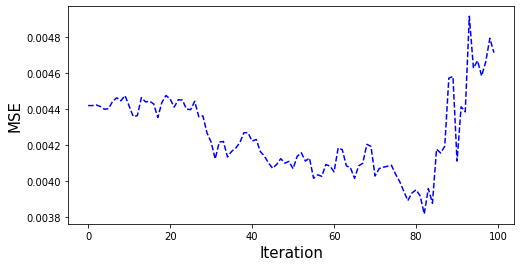

0.0038194305


In [ ]:
plot_graph(validation_MSE, 'MSE', 'Iteration', 'b')
print(np.min(validation_MSE))

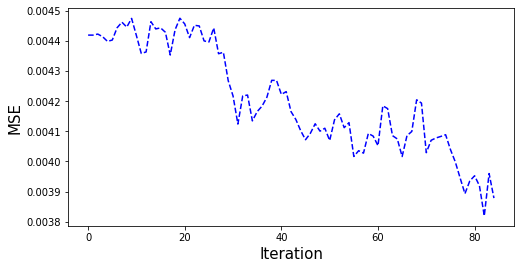

0.0038194305


In [ ]:
plot_graph(validation_MSE[:85], 'MSE', 'Iteration', 'b')
print(np.min(validation_MSE))

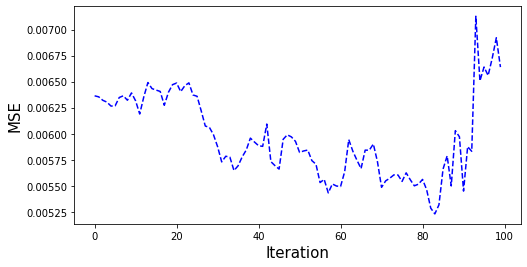

0.005228649


In [ ]:
plot_graph(test_MSE, 'MSE', 'Iteration', 'b')
print(np.min(test_MSE))

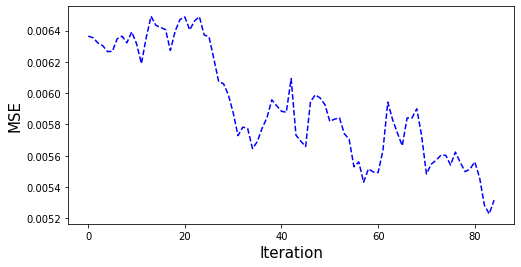

0.005228649


In [ ]:
plot_graph(test_MSE[:85], 'MSE', 'Iteration', 'b')
print(np.min(test_MSE))

In [ ]:
tf.keras.backend.clear_session()

simple_model = Sequential()

simple_model.add(Dense(units=32, input_dim=10, activation='relu'))
simple_model.add(Dense(8, activation='relu'))
simple_model.add(Dense(1))

simple_model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse', 'mae'])

simple_model.set_weights(random_weights)

simple_model.fit(X_train,
                 y_train,
                 epochs=500,
                 validation_data=(X_validation, y_validation),
                 callbacks=[early_stop_callback],
                 shuffle=False)

Epoch 1/500
44/44 [==============================] - 1s 6ms/step - loss: 68820.7656 - mse: 68820.7656 - mae: 253.9157 - val_loss: 66611.8203 - val_mse: 66611.8203 - val_mae: 255.3170
Epoch 2/500
44/44 [==============================] - 0s 2ms/step - loss: 43391.3828 - mse: 43391.3828 - mae: 201.5821 - val_loss: 43470.7422 - val_mse: 43470.7422 - val_mae: 206.2531
Epoch 3/500
44/44 [==============================] - 0s 2ms/step - loss: 29038.6523 - mse: 29038.6523 - mae: 164.8938 - val_loss: 29784.0371 - val_mse: 29784.0371 - val_mae: 170.7228
Epoch 4/500
44/44 [==============================] - 0s 2ms/step - loss: 20251.2285 - mse: 20251.2285 - mae: 137.6932 - val_loss: 21128.2227 - val_mse: 21128.2227 - val_mae: 143.7900
Epoch 5/500
44/44 [==============================] - 0s 2ms/step - loss: 14556.3955 - mse: 14556.3955 - mae: 116.7316 - val_loss: 15384.4541 - val_mse: 15384.4541 - val_mae: 122.6975
Epoch 6/500
44/44 [==============================] - 0s 2ms/step - loss: 10707.2168 -

In [ ]:
simple_model_pred_validation = simple_model.predict(X_validation)
print(mean_squared_error(y_validation, simple_model_pred_validation))

0.0043867948


In [ ]:
simple_model_pred_test = simple_model.predict(X_test)
print(mean_squared_error(y_test, simple_model_pred_test))

0.0063303695


In [ ]:
improved_model = get_model()

for i in range(len(improved_model.layers)):
  improved_model.layers[i].set_weights(best_model_weights[i])

improved_model_pred_validation = improved_model.predict(X_validation)
print(mean_squared_error(y_validation, improved_model_pred_validation))

0.0038194305


In [ ]:
improved_model_pred_test = improved_model.predict(X_test)
print(mean_squared_error(y_test, improved_model_pred_test))

0.00528409
